# Fine-tune LLM with PyTorch FSDP and QLora on Amazon SageMaker AI using ModelTrainer

In this notebook, we will fine-tune LLM on Amazon SageMaker AI, using Python scripts and SageMaker ModelTrainer for executing a training job.

## Prerequisites

In [1]:
%pip install -r ./scripts/requirements.txt --upgrade

  Using cached transformers-4.52.2-py3-none-any.whl.metadata (40 kB)
  Using cached tokenizers-0.22.2-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.3 kB)
  Using cached trl-0.18.0-py3-none-any.whl.metadata (11 kB)
Using cached transformers-4.52.2-py3-none-any.whl (10.5 MB)
Using cached trl-0.18.0-py3-none-any.whl (366 kB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.0
    Uninstalling transformers-4.53.0:━━━━━━━━━━━ 0/2 [transformers]
      Successfully uninstalled transformers-4.53.00/2 [transformers]
  Attempting uninstall: trl━━━━━━━━━━━━━━━━━━━━━ 0/2 [transformers]
    Found existing installation: trl 0.9.6━━ 0/2 [transformers]
    Uninstalling trl-0.9.6:━━━━━━━━━━━━━━━━━ 0/2 [transformers]
      Successfully uninstalled trl-0.9.6━━━━ 0/2 [transformers]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [trl]1/2 [trl]
ERROR: pip's dependency resolver does not currently take into account all the packages that are install

## This cell will restart the kernel. Click "OK".

In [2]:
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

***

## Setup Configuration file path

If you have created a Managed MLflow server, copy the `ARN` code here and assign a name to the experiment

In [1]:
import boto3
import shutil
from sagemaker.core.helper.session_helper import Session, get_execution_role
from sagemaker.core.config import load_sagemaker_config

sagemaker_session = Session()
s3_client = boto3.client('s3')

region = sagemaker_session.boto_session.region_name
bucket_name = sagemaker_session.default_bucket()
default_prefix = sagemaker_session.default_bucket_prefix
configs = load_sagemaker_config()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


If you have your own MLflow tracking server, update the `TrackingServerName` value below to enable experiment tracking.

In [3]:
from botocore.exceptions import ClientError

try:
    response = boto3.client('sagemaker').describe_mlflow_tracking_server(
        TrackingServerName='genai-mlflow-tracker'
    )
    mlflow_tracking_server_uri = response['TrackingServerArn']
except ClientError:
    mlflow_tracking_server_uri = ""

if mlflow_tracking_server_uri == "":
    print("No MLflow Tracking Server Found, experiments will not be tracked.")
else:
    print(f"MLflow Tracking Server ARN: {mlflow_tracking_server_uri}")

No MLflow Tracking Server Found, experiments will not be tracked.


In [4]:
import os

os.environ["mlflow_uri"] = mlflow_tracking_server_uri
os.environ["mlflow_experiment_name"] = "Qwen3-4B-Instruct-2507-sft"

***

## Visualize and upload the dataset

We are going to load [FreedomIntelligence/medical-o1-reasoning-SFT](https://huggingface.co/datasets/FreedomIntelligence/medical-o1-reasoning-SFT) dataset

In [5]:
from datasets import load_dataset
import pandas as pd

num_samples = 100

full_dataset = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT", "en", split=f"train[:{num_samples}]")

full_dataset[0]

[02/13/26 21:09:11] INFO     PyTorch version 2.6.0 available.                                          ]8;id=159480;file:///opt/conda/lib/python3.12/site-packages/datasets/config.py\config.py]8;;\:]8;id=518805;file:///opt/conda/lib/python3.12/site-packages/datasets/config.py#54\54]8;;\

                    INFO     Duckdb version 1.4.3 available.                                           ]8;id=140132;file:///opt/conda/lib/python3.12/site-packages/datasets/config.py\config.py]8;;\:]8;id=349731;file:///opt/conda/lib/python3.12/site-packages/datasets/config.py#77\77]8;;\

                    INFO     TensorFlow version 2.18.0 available.                                     ]8;id=5489;file:///opt/conda/lib/python3.12/site-packages/datasets/config.py\config.py]8;;\:]8;id=799847;file:///opt/conda/lib/python3.12/site-packages/datasets/config.py#112\112]8;;\

{'Question': 'Given the symptoms of sudden weakness in the left arm and leg, recent long-distance travel, and the presence of swollen and tender right lower leg, what specific cardiac abnormality is most likely to be found upon further evaluation that could explain these findings?',
 'Complex_CoT': "Okay, let's see what's going on here. We've got sudden weakness in the person's left arm and leg - and that screams something neuro-related, maybe a stroke?\n\nBut wait, there's more. The right lower leg is swollen and tender, which is like waving a big flag for deep vein thrombosis, especially after a long flight or sitting around a lot.\n\nSo, now I'm thinking, how could a clot in the leg end up causing issues like weakness or stroke symptoms?\n\nOh, right! There's this thing called a paradoxical embolism. It can happen if there's some kind of short circuit in the heart - like a hole that shouldn't be there.\n\nLet's put this together: if a blood clot from the leg somehow travels to the l

In [6]:
train_test_split_datasets = full_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = train_test_split_datasets["train"]
test_dataset = train_test_split_datasets["test"]

print(f"Number of train elements: {len(train_dataset)}")
print(f"Number of test elements: {len(test_dataset)}")

Number of train elements: 90
Number of test elements: 10


Create a prompt template and load the dataset with a random sample to try summarization.

In [7]:
SYSTEM_PROMPT = """You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning. 
Below is an instruction that describes a task, paired with an input that provides further context. 
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response."""


# template dataset to add prompt to each sample
def convert_to_messages(sample, system_prompt=""):
    
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": sample["Question"]},
        {"role": "assistant", "content": f"{sample['Complex_CoT']}\n\n{sample['Response']}"}
    ]

    sample["messages"] = messages
    
    return sample

Use the Hugging Face Trainer class to fine-tune the model. Define the hyperparameters we want to use.

In [8]:
from random import randint

train_dataset = train_dataset.map(convert_to_messages, remove_columns=list(full_dataset.features), fn_kwargs={"system_prompt": SYSTEM_PROMPT})
test_dataset = test_dataset.map(convert_to_messages, remove_columns=list(full_dataset.features), fn_kwargs={"system_prompt": SYSTEM_PROMPT})

#grab a sample from the training and test sets
print(f"Train Sample:\n{train_dataset[randint(0, len(train_dataset)-1)]}\n\n")
print(f"Test Sample:\n{test_dataset[randint(0, len(test_dataset)-1)]}\n\n")

Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Train Sample:
{'messages': [{'content': 'You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning. \nBelow is an instruction that describes a task, paired with an input that provides further context. \nWrite a response that appropriately completes the request.\nBefore answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.', 'role': 'system'}, {'content': 'What is the recommended approach for initiating treatment of hypothyroidism in a patient with ischemic heart disease?', 'role': 'user'}, {'content': "Okay, so we've got a patient with both hypothyroidism and ischemic heart disease. That's quite a combination because we need to be really careful with how we manage the thyroid issue without putting too much strain on the heart. Hypothyroidism means they need more thyroid hormone, usually with levothyroxine. But, there's a catch. Thyroid hormones tend to speed 

### Upload to Amazon S3

In [9]:
# save train_dataset to s3 using our SageMaker session
if default_prefix:
    input_path = f'{default_prefix}/datasets/llm-fine-tuning-modeltrainer-sft'
else:
    input_path = f'datasets/llm-fine-tuning-modeltrainer-sft'

# Save datasets to s3
train_dataset.to_json("./data/train/dataset.json", orient="records")
test_dataset.to_json("./data/test/dataset.json", orient="records")

s3_client.upload_file("./data/train/dataset.json", bucket_name, f"{input_path}/train/dataset.json")
train_dataset_s3_path = f"s3://{bucket_name}/{input_path}/train/dataset.json"
s3_client.upload_file("./data/test/dataset.json", bucket_name, f"{input_path}/test/dataset.json")
test_dataset_s3_path = f"s3://{bucket_name}/{input_path}/test/dataset.json"

shutil.rmtree("./data")

print(f"Training data uploaded to:")
print(train_dataset_s3_path)
print(test_dataset_s3_path)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Training data uploaded to:
s3://sagemaker-us-west-2-143709572556/datasets/llm-fine-tuning-modeltrainer-sft/train/dataset.json
s3://sagemaker-us-west-2-143709572556/datasets/llm-fine-tuning-modeltrainer-sft/test/dataset.json


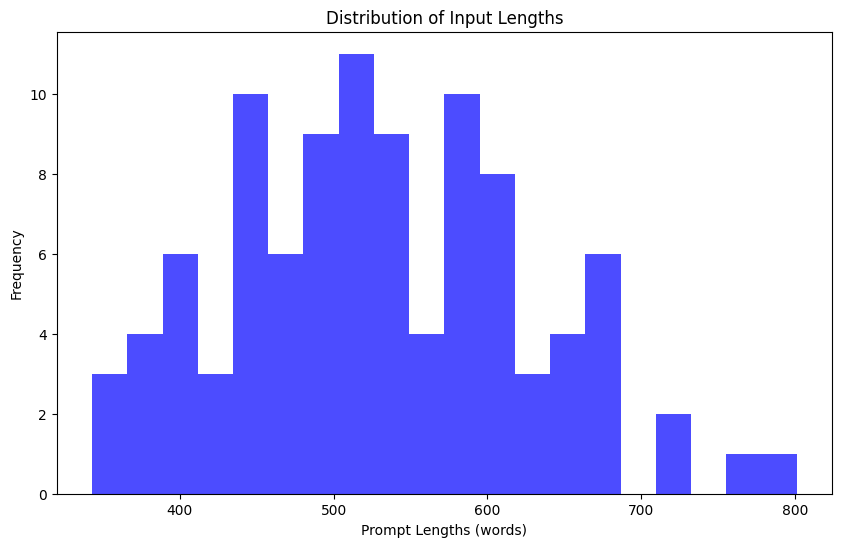

In [10]:
from utils import plot_length_distribution

plot_length_distribution(
    train_dataset=train_dataset,
    validation_dataset=test_dataset,
    bins=20,
    figsize=(10, 6)
)

***

## Model fine-tuning

We are now ready to fine-tune our model.

In [11]:
model_id = "Qwen/Qwen3-4B-Instruct-2507"
model_id_filesafe = model_id.replace("/","_")

use_local_model = True #set to false for the training job to download from HF, otherwise True will download locally

In [12]:
from huggingface_hub import snapshot_download
import os
import subprocess

if use_local_model:

    model_local_location = f"../models/{model_id_filesafe}"
    print("Downloading model ", model_id)
    os.makedirs(model_local_location, exist_ok=True)
    snapshot_download(repo_id=model_id, local_dir=model_local_location)
    print(f"Model {model_id} downloaded under {model_local_location}")

    if default_prefix:
        model_s3_destination = f"s3://{bucket_name}/{default_prefix}/models/{model_id_filesafe}"
    else:
        model_s3_destination = f"s3://{bucket_name}/models/{model_id_filesafe}"
    
    print(f"Beginning Model Upload...")

    subprocess.run(['aws', 's3', 'cp', model_local_location, model_s3_destination, '--recursive', '--exclude', '.cache/*', '--exclude', '.gitattributes'])
    
    print(f"Model Uploaded to: \n {model_s3_destination}")

    os.environ["model_location"] = model_s3_destination
else:
    os.environ["model_location"] = model_id

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Model Qwen/Qwen3-4B-Instruct-2507 downloaded under ../models/Qwen_Qwen3-4B-Instruct-2507
Beginning Model Upload...
upload: ../models/Qwen_Qwen3-4B-Instruct-2507/generation_config.json to s3://sagemaker-us-west-2-143709572556/models/Qwen_Qwen3-4B-Instruct-2507/generation_config.json
upload: ../models/Qwen_Qwen3-4B-Instruct-2507/LICENSE to s3://sagemaker-us-west-2-143709572556/models/Qwen_Qwen3-4B-Instruct-2507/LICENSE
upload: ../models/Qwen_Qwen3-4B-Instruct-2507/README.md to s3://sagemaker-us-west-2-143709572556/models/Qwen_Qwen3-4B-Instruct-2507/README.md
upload: ../models/Qwen_Qwen3-4B-Instruct-2507/config.json to s3://sagemaker-us-west-2-143709572556/models/Qwen_Qwen3-4B-Instruct-2507/config.json
upload: ../models/Qwen_Qwen3-4B-Instruct-2507/merges.txt to s3://sagemaker-us-west-2-143709572556/models/Qwen_Qwen3-4B-Instruct-2507/merges.txt
upload: ../models/Qwen_Qwen3-4B-Instruct-2507/model-00001-of-00003.safetensors to s3://sagemaker-us-west-2-143709572556/models/Qwen_Qwen3-4B-Instru

In [13]:
%%bash

cat > ./args.yaml <<EOF

# MLflow Config
mlflow_uri: "${mlflow_uri}"
mlflow_experiment_name: "${mlflow_experiment_name}"


model_id: "${model_location}"       # Hugging Face model id, or S3 location

# sagemaker specific parameters
output_dir: "/opt/ml/model"                       # path to where SageMaker will upload the model 
train_dataset_path: "/opt/ml/input/data/train/"   # path to where FSx saves train dataset
test_dataset_path: "/opt/ml/input/data/test/"     # path to where FSx saves test dataset
# training parameters
max_seq_length: 1500  #512 # 2048
lora_r: 8
lora_alpha: 16
lora_dropout: 0.1                 
learning_rate: 2e-4                    # learning rate scheduler
num_train_epochs: 1                    # number of training epochs
per_device_train_batch_size: 2         # batch size per device during training
per_device_eval_batch_size: 1          # batch size for evaluation
gradient_accumulation_steps: 2         # number of steps before performing a backward/update pass
gradient_checkpointing: true           # use gradient checkpointing
fp16: true
bf16: false                            # use bfloat16 precision
tf32: false                            # use tf32 precision

merge_weights: true                    # merge weights in the base model
EOF

Lets upload the config file to S3.

In [14]:
from sagemaker.core.s3 import S3Uploader

if default_prefix:
    input_path = f"s3://{bucket_name}/{default_prefix}/training_config/{model_id_filesafe}"
else:
    input_path = f"s3://{bucket_name}/training_config/{model_id_filesafe}"

# upload the model yaml file to s3
model_yaml = "args.yaml"
train_config_s3_path = S3Uploader.upload(local_path=model_yaml, desired_s3_uri=f"{input_path}/config")

print(f"Training config uploaded to:")
print(train_config_s3_path)

Training config uploaded to:
s3://sagemaker-us-west-2-143709572556/training_config/Qwen_Qwen3-4B-Instruct-2507/config/args.yaml


## Fine-tune model

Below will train the model with QLoRA, merge the adapter in the base model and save in S3

#### Get PyTorch image_uri

In [15]:
instance_type = "ml.g5.2xlarge"

instance_type

'ml.g5.2xlarge'

In [16]:
from sagemaker.core import image_uris

image_uri = image_uris.retrieve(
    framework="pytorch",
    region=sagemaker_session.boto_session.region_name,
    version="2.6.0",
    instance_type=instance_type,
    image_scope="training"
)

image_uri

[02/13/26 21:09:52] INFO     Defaulting to only available Python version: py312                   ]8;id=268664;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/image_uris.py\image_uris.py]8;;\:]8;id=317614;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/image_uris.py#615\615]8;;\

'763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-training:2.6.0-gpu-py312'

In [17]:
from sagemaker.train.model_trainer import ModelTrainer, InputData, Torchrun, StoppingCondition
from sagemaker.core.training.configs import Compute, SourceCode
from sagemaker.core.shapes import OutputDataConfig

# Define the script to be run
source_code = SourceCode(
    source_dir="./scripts",
    requirements="requirements.txt",
    entry_script="train.py",
)

# Define the compute
compute_configs = Compute(
    instance_type=instance_type,
    instance_count=1,
    keep_alive_period_in_seconds=3600,
    volume_size_in_gb=50
)

# define Training Job Name 
job_name = f"train-{model_id.split('/')[-1].replace('.', '-')}-sft-script"

# define OutputDataConfig path
if default_prefix:
    output_path = f"s3://{bucket_name}/{default_prefix}/{job_name}"
else:
    output_path = f"s3://{bucket_name}/{job_name}"

# Define the ModelTrainer
model_trainer = ModelTrainer(
    training_image=image_uri,
    source_code=source_code,
    base_job_name=job_name,
    compute=compute_configs,
    distributed=Torchrun(),
    stopping_condition=StoppingCondition(
        max_runtime_in_seconds=7200
    ),
    hyperparameters={
        "config": "/opt/ml/input/data/config/args.yaml"
    },
    output_data_config=OutputDataConfig(
        s3_output_path=output_path
    ),
    environment={
        "PYTORCH_CUDA_ALLOC_CONF": "expandable_segments:True"
    }
)

[02/13/26 21:09:55] INFO     SageMaker session not provided. Using default Session.                  ]8;id=907307;file:///opt/conda/lib/python3.12/site-packages/sagemaker/train/defaults.py\defaults.py]8;;\:]8;id=51661;file:///opt/conda/lib/python3.12/site-packages/sagemaker/train/defaults.py#61\61]8;;\

                    INFO     Role not provided. Using default role:                                  ]8;id=721014;file:///opt/conda/lib/python3.12/site-packages/sagemaker/train/defaults.py\defaults.py]8;;\:]8;id=791741;file:///opt/conda/lib/python3.12/site-packages/sagemaker/train/defaults.py#75\75]8;;\
                             arn:aws:iam::143709572556:role/service-role/AmazonSageMaker-ExecutionRo               
                             le-20260106T121900                                                                    

                    INFO     Training image URI:                                               ]8;id=231023;file:///opt/conda/lib/python3.12/site-packages/sagemaker/train/model_trainer.py\model_trainer.py]8;;\:]8;id=372132;file:///opt/conda/lib/python3.12/site-packages/sagemaker/train/model_trainer.py#548\548]8;;\
                             763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-training:2.6                     
                             .0-gpu-py312                                                                          

In [18]:
# Pass the input data
train_input = InputData(
    channel_name="train",
    data_source=train_dataset_s3_path,
)

test_input = InputData(
    channel_name="test",
    data_source=test_dataset_s3_path,
)

config_input = InputData(
    channel_name="config",
    data_source=train_config_s3_path,
)

# Check input channels configured
data = [train_input, test_input, config_input]
data

[InputData(channel_name='train', data_source='s3://sagemaker-us-west-2-143709572556/datasets/llm-fine-tuning-modeltrainer-sft/train/dataset.json', content_type=None),
 InputData(channel_name='test', data_source='s3://sagemaker-us-west-2-143709572556/datasets/llm-fine-tuning-modeltrainer-sft/test/dataset.json', content_type=None),
 InputData(channel_name='config', data_source='s3://sagemaker-us-west-2-143709572556/training_config/Qwen_Qwen3-4B-Instruct-2507/config/args.yaml', content_type=None)]

In [26]:
# starting the train job with our uploaded datasets as input
model_trainer.train(input_data_config=data, wait=True)

[02/13/26 21:15:12] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=946452;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=939190;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/telemetry/telemetry_logging.py#92\92]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training_job resource.                                     ]8;id=763229;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=65211;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35539\35539]8;;\

Output()

[02/13/26 21:21:02] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=689308;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=158963;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Starting training script                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=352698;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=1797;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ++ /usr/local/bin/python3 --version                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=514363;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=441251;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Python 3.12.8                                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=45947;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=508063;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ++ echo /opt/ml/input/config/resourceconfig.json:                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=340021;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=908955;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ++ cat /opt/ml/input/config/resourceconfig.json                                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=205467;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=589924;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             /opt/ml/input/config/resourceconfig.json:                                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=802583;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=871679;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ++ echo                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=443829;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=797068;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ++ echo /opt/ml/input/config/inputdataconfig.json:                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=760521;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=583381;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ++ cat /opt/ml/input/config/inputdataconfig.json                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=349073;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=926112;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             {"current_host":"algo-1","current_instance_type":"ml.g5.2xlarge","c                   
                             urrent_group_name":"homogeneousCluster","hosts":["algo-1"],"instanc                   
                             e_groups":[{"instance_group_name":"homogeneousCluster","instance_ty                   
                             pe":"ml.g5.2xlarge","hosts":["algo-1"]}],"network_interface_name":"                   
                             eth0","topology":null}                                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=985514;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=608955;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             /opt/ml/input/config/inputdataconfig.json:                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=827518;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=704816;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ++ echo                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=342573;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=254863;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ++ echo 'Setting up environment variables'                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=953185;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=722927;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ++ /usr/local/bin/python3                                                             
                             /opt/ml/input/data/sm_drivers/scripts/environment.py                                  

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=885222;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=810851;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             {"code":{"TrainingInputMode":"File","S3DistributionType":"FullyRepl                   
                             icated","RecordWrapperType":"None"},"config":{"TrainingInputMode":"                   
                             File","S3DistributionType":"FullyReplicated","RecordWrapperType":"N                   
                             one"},"sm_drivers":{"TrainingInputMode":"File","S3DistributionType"                   
                             :"FullyReplicated","RecordWrapperType":"None"},"test":{"TrainingInp                   
                             utMode":"File","S3DistributionType":"FullyReplicated","RecordWrappe                   
                             rType":"None"},"train":{"TrainingInputMode":"File","S3DistributionT                   
                             ype":"FullyReplicated","RecordWrapperType":"None"}}                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=897725;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=653294;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Setting up environment variables                                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=981723;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=153496;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             No Neurons detected (normal if no neurons installed)                                  

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=594711;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=974253;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Environment Variables:                                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=414819;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=508093;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             NVTE_FRAMEWORK=pytorch                                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=789832;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=143621;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             NVIDIA_VISIBLE_DEVICES=all                                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=53987;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=523402;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             PYTHONUNBUFFERED=1                                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=751062;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=568250;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             AWS_CONTAINER_CREDENTIALS_RELATIVE_URI=******                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=607659;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=197414;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SAGEMAKER_TRAINING_MODULE=sagemaker_pytorch_container.training:main                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=153747;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=474963;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             HOSTNAME=ip-10-0-246-170.us-west-2.compute.internal                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=928024;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=406619;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             NVIDIA_REQUIRE_CUDA=cuda>=12.6 brand=unknown,driver>=470,driver<471                   
                             brand=grid,driver>=470,driver<471                                                     
                             brand=tesla,driver>=470,driver<471                                                    
                             brand=nvidia,driver>=470,driver<471                                                   
                             brand=quadro,driver>=470,driver<471                                                   
                             brand=quadrortx,driver>=470,driver<471                                                
                             brand=nvidiartx,driver>=470,driver<471                                                
                             brand=vapps,driver>=470,driver<471 brand=vpc,driver>=470,driver<471                   
                             brand=vcs,driver>=470,driver<471 brand=vws,driver>=470,driver<471                     
                             brand=cloudgaming,driver>=470,driver<471                                              
                             brand=unknown,driver>=535,driver<536                                                  
                             brand=grid,driver>=535,driver<536                                                     
                             brand=tesla,driver>=535,driver<536                                                    
                             brand=nvidia,driver>=535,driver<536                                                   
                             brand=quadro,driver>=535,driver<536                                                   
                             brand=quadrortx,driver>=535,driver<536                                                
                             brand=nvidiartx,driver>=535,driver<536                                                
                             brand=vapps,driver>=535,driver<536 brand=vpc,driver>=535,driver<536                   
                             brand=vcs,driver>=535,driver<536 brand=vws,driver>=535,driver<536                     
                             brand=cloudgaming,driver>=535,driver<536                                              
                             brand=unknown,driver>=550,driver<551                                                  
                             brand=grid,driver>=550,driver<551                                                     
                             brand=tesla,driver>=550,driver<551                                                    
                             brand=nvidia,driver>=550,driver<551                                                   
                             brand=quadro,driver>=550,driver<551                                                   
                             brand=quadrortx,driver>=550,driver<551                                                
                             brand=nvidiartx,driver>=550,driver<551                                                
                             brand=vapps,driver>=550,driver<551 brand=vpc,driver>=550,driver<551                   
                             brand=vcs,driver>=550,driver<551 brand=vws,driver>=550,driver<551                     
                             brand=cloudgaming,driver>=550,driver<551                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=625909;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=584295;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             TORCH_NVCC_FLAGS=-Xfatbin -compress-all                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=482061;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=494171;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             AWS_REGION=us-west-2                                                                  

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=535307;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=805562;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             PWD=/                                                                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=986688;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=40714;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SAGEMAKER_MANAGED_WARMPOOL_CACHE_DIRECTORY=/opt/ml/sagemaker/warmpo                   
                             olcache                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=87369;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=293664;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             NVIDIA_DRIVER_CAPABILITIES=compute,utility,compat32,graphics,video                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=307615;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=279099;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             OPEN_MPI_PATH=/opt/amazon/openmpi                                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=269232;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=162149;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             NV_CUDA_CUDART_VERSION=12.6.77-1                                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=666541;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=23283;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             HOME=/root                                                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=458688;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=888103;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             LANG=C.UTF-8                                                                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=993917;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=133865;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             CUDA_VERSION=12.6.3                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=260851;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=844412;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             DMLC_INTERFACE=eth0                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=45331;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=646194;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=246775;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=426994;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             PYTHONIOENCODING=UTF-8                                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=762538;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=539954;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SHLVL=1                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=337020;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=671812;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             NVARCH=x86_64                                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=190900;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=531660;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             PYTHONDONTWRITEBYTECODE=1                                                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=960940;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=873807;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             LD_LIBRARY_PATH=/opt/amazon/openmpi/lib:/opt/amazon/efa/lib:/lib/x8                   
                             6_64-linux-gnu:/usr/local/lib:/usr/local/lib:/usr/local/nvidia/lib:                   
                             /usr/local/nvidia/lib64                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=139442;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=74128;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             TRAINING_JOB_NAME=train-Qwen3-4B-Instruct-2507-sft-script-202602132                   
                             11512                                                                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=297654;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=298308;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             LC_ALL=C.UTF-8                                                                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=976052;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=306896;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             EFA_PATH=/opt/amazon/efa                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=625211;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=884585;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             TRAINING_JOB_ARN=arn:aws:sagemaker:us-west-2:143709572556:training-                   
                             job/train-Qwen3-4B-Instruct-2507-sft-script-20260213211512                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=325885;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=579148;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             CUDA_HOME=/usr/local/cuda                                                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=547674;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=320272;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             PATH=/usr/local/bin:/opt/amazon/openmpi/bin:/opt/amazon/efa/bin:/us                   
                             r/local/cuda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/loc                   
                             al/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin                                  

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=24652;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=916421;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             DEBIAN_FRONTEND=noninteractive                                                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=651284;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=152716;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             CACHE_BUST_SETUPTOOLS_FIX=20260128                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=856467;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=331134;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             DLC_CONTAINER_TYPE=training                                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=85777;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=759811;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             _=/usr/local/bin/python3                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=818705;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=338354;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_MODEL_DIR=/opt/ml/model                                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=54382;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=187388;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_INPUT_DIR=/opt/ml/input                                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=535913;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=727812;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_INPUT_DATA_DIR=/opt/ml/input/data                                                  

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=220924;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=863550;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_INPUT_CONFIG_DIR=/opt/ml/input/config                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=331018;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=363104;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_OUTPUT_DIR=/opt/ml/output                                                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=746153;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=343676;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_OUTPUT_FAILURE=/opt/ml/output/failure                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=153977;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=258758;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_OUTPUT_DATA_DIR=/opt/ml/output/data                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=180579;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=528271;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_LOG_LEVEL=20                                                                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=550757;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=892456;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_MASTER_ADDR=algo-1                                                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=56886;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=759902;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_MASTER_PORT=7777                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=473839;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=213052;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_SOURCE_DIR=/opt/ml/input/data/code                                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=247996;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=353927;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_ENTRY_SCRIPT=train.py                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=580917;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=614685;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_DISTRIBUTED_DRIVER_DIR=/opt/ml/input/data/sm_drivers/distributed                   
                             _drivers                                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=830638;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=307784;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_DISTRIBUTED_CONFIG={"process_count_per_node": null, "smp": null}                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=619526;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=89094;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_CHANNEL_CODE=/opt/ml/input/data/code                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=140280;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=260417;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_CHANNEL_CONFIG=/opt/ml/input/data/config                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=640039;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=298664;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_CHANNEL_SM_DRIVERS=/opt/ml/input/data/sm_drivers                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=819455;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=8145;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_CHANNEL_TEST=/opt/ml/input/data/test                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=728013;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=305657;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_CHANNEL_TRAIN=/opt/ml/input/data/train                                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=649152;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=288191;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_CHANNELS=['code', 'config', 'sm_drivers', 'test', 'train']                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=195335;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=502586;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_HP_CONFIG=/opt/ml/input/data/config/args.yaml                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=620918;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=114957;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_HPS={"config": "/opt/ml/input/data/config/args.yaml"}                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=550796;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=908549;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_CURRENT_HOST=algo-1                                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=316244;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=383808;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_CURRENT_INSTANCE_TYPE=ml.g5.2xlarge                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=946489;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=69488;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_HOSTS=['algo-1']                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=820148;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=456146;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_NETWORK_INTERFACE_NAME=eth0                                                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=393391;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=10621;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_HOST_COUNT=1                                                                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=294595;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=377484;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_CURRENT_HOST_RANK=0                                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=30470;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=502027;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_NUM_CPUS=8                                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=49202;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=179680;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_NUM_GPUS=1                                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=179669;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=213455;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_NUM_NEURONS=0                                                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=110161;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=992239;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_RESOURCE_CONFIG={"current_host": "algo-1",                                         
                             "current_instance_type": "ml.g5.2xlarge", "current_group_name":                       
                             "homogeneousCluster", "hosts": ["algo-1"], "instance_groups":                         
                             [{"instance_group_name": "homogeneousCluster", "instance_type":                       
                             "ml.g5.2xlarge", "hosts": ["algo-1"]}], "network_interface_name":                     
                             "eth0", "topology": null}                                                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=239822;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=49877;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_INPUT_DATA_CONFIG={"code": {"TrainingInputMode": "File",                           
                             "S3DistributionType": "FullyReplicated", "RecordWrapperType":                         
                             "None"}, "config": {"TrainingInputMode": "File",                                      
                             "S3DistributionType": "FullyReplicated", "RecordWrapperType":                         
                             "None"}, "sm_drivers": {"TrainingInputMode": "File",                                  
                             "S3DistributionType": "FullyReplicated", "RecordWrapperType":                         
                             "None"}, "test": {"TrainingInputMode": "File",                                        
                             "S3DistributionType": "FullyReplicated", "RecordWrapperType":                         
                             "None"}, "train": {"TrainingInputMode": "File",                                       
                             "S3DistributionType": "FullyReplicated", "RecordWrapperType":                         
                             "None"}}                                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=501591;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=37358;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             SM_TRAINING_ENV={"channel_input_dirs": {"code":                                       
                             "/opt/ml/input/data/code", "config": "/opt/ml/input/data/config",                     
                             "sm_drivers": "/opt/ml/input/data/sm_drivers", "test":                                
                             "/opt/ml/input/data/test", "train": "/opt/ml/input/data/train"},                      
                             "current_host": "algo-1", "current_instance_type": "ml.g5.2xlarge",                   
                             "hosts": ["algo-1"], "master_addr": "algo-1", "master_port": 7777,                    
                             "hyperparameters": {"config":                                                         
                             "/opt/ml/input/data/config/args.yaml"}, "input_data_config":                          
                             {"code": {"TrainingInputMode": "File", "S3DistributionType":                          
                             "FullyReplicated", "RecordWrapperType": "None"}, "config":                            
                             {"TrainingInputMode": "File", "S3DistributionType":                                   
                             "FullyReplicated", "RecordWrapperType": "None"}, "sm_drivers":                        
                             {"TrainingInputMode": "File", "S3DistributionType":                                   
                             "FullyReplicated", "RecordWrapperType": "None"}, "test":                              
                             {"TrainingInputMode": "File", "S3DistributionType":                                   
                             "FullyReplicated", "RecordWrapperType": "None"}, "train":                             
                             {"TrainingInputMode": "File", "S3DistributionType":                                   
                             "FullyReplicated", "RecordWrapperType": "None"}},                                     
                             "input_config_dir": "/opt/ml/input/config", "input_data_dir":                         
                             "/opt/ml/input/data", "input_dir": "/opt/ml/input", "job_name":                       
                             "train-Qwen3-4B-Instruct-2507-sft-script-20260213211512",                             
                             "log_level": 20, "model_dir": "/opt/ml/model",                                        
                             "network_interface_name": "eth0", "num_cpus": 8, "num_gpus": 1,                       
                             "num_neurons": 0, "output_data_dir": "/opt/ml/output/data",                           
                             "resource_config": {"current_host": "algo-1",                                         
                             "current_instance_type": "ml.g5.2xlarge", "current_group_name":                       
                             "homogeneousCluster", "hosts": ["algo-1"], "instance_groups":                         
                             [{"instance_group_name": "homogeneousCluster", "instance_type":                       
                             "ml.g5.2xlarge", "hosts": ["algo-1"]}], "network_interface_name":                     
                             "eth0", "topology": null}}                                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=477112;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=455877;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ++ set +x                                                                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=556506;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=938065;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ++ cd /opt/ml/input/data/code                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=480572;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=126117;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Installing requirements                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=41619;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=618237;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ++ echo 'Installing requirements'                                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=194995;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=43605;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ++ /usr/local/bin/pip3 install -r requirements.txt                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=944162;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=883021;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting transformers==4.52.2 (from -r requirements.txt (line 1))                   
                               Downloading transformers-4.52.2-py3-none-any.whl.metadata (40 kB)                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=538862;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=176391;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting peft==0.14.0 (from -r requirements.txt (line 2))                           
                               Downloading peft-0.14.0-py3-none-any.whl.metadata (13 kB)                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=676875;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=617552;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting accelerate==1.3.0 (from -r requirements.txt (line 3))                      
                               Downloading accelerate-1.3.0-py3-none-any.whl.metadata (19 kB)                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=819946;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=331641;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting bitsandbytes==0.45.1 (from -r requirements.txt (line 4))                   
                               Downloading                                                                         
                             bitsandbytes-0.45.1-py3-none-manylinux_2_24_x86_64.whl.metadata                       
                             (5.8 kB)                                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=820546;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=369768;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting datasets==3.2.0 (from -r requirements.txt (line 5))                        
                               Downloading datasets-3.2.0-py3-none-any.whl.metadata (20 kB)                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=612708;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=661732;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting evaluate==0.4.3 (from -r requirements.txt (line 6))                        
                               Downloading evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=665494;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=880428;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting huggingface_hub==0.33.4 (from                                              
                             huggingface_hub==0.33.4->-r requirements.txt (line 7))                                
                               Downloading huggingface_hub-0.33.4-py3-none-any.whl.metadata (14                    
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=285651;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=267461;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting mlflow==3.9.0 (from -r requirements.txt (line 8))                          
                               Downloading mlflow-3.9.0-py3-none-any.whl.metadata (31 kB)                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=346186;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=341083;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: safetensors>=0.5.2 in                                  
                             /usr/local/lib/python3.12/site-packages (from -r requirements.txt                     
                             (line 9)) (0.7.0)                                                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=213797;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=901629;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting sagemaker==3.4.0 (from -r requirements.txt (line 10))                      
                               Downloading sagemaker-3.4.0-py3-none-any.whl.metadata (20 kB)                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=883910;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=113797;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting sagemaker-mlflow==0.2.0 (from -r requirements.txt (line                    
                             11))                                                                                  
                               Downloading sagemaker_mlflow-0.2.0-py3-none-any.whl.metadata (3.9                   
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=179454;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=24209;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting sentencepiece==0.2.0 (from -r requirements.txt (line                       
                             12))                                                                                  
                               Downloading                                                                         
                             sentencepiece-0.2.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014                   
                             _x86_64.whl.metadata (7.7 kB)                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=799968;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=779682;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting scikit-learn==1.6.1 (from -r requirements.txt (line 13))                   
                               Downloading                                                                         
                             scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_                   
                             x86_64.whl.metadata (18 kB)                                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=199421;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=980638;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting tokenizers>=0.21.0 (from -r requirements.txt (line 14))                    
                               Downloading                                                                         
                             tokenizers-0.22.2-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86                   
                             _64.whl.metadata (7.3 kB)                                                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=67551;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=642639;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting trl==0.18.0 (from -r requirements.txt (line 15))                           
                               Downloading trl-0.18.0-py3-none-any.whl.metadata (11 kB)                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=804012;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=490065;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting psutil==7.1.0 (from -r requirements.txt (line 16))                         
                               Downloading                                                                         
                             psutil-7.1.0-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.m                   
                             anylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (23 kB)                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=885836;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=471104;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting py7zr==1.0.0 (from -r requirements.txt (line 17))                          
                               Downloading py7zr-1.0.0-py3-none-any.whl.metadata (17 kB)                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=57235;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=958820;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting pynvml==13.0.1 (from -r requirements.txt (line 18))                        
                               Downloading pynvml-13.0.1-py3-none-any.whl.metadata (5.6 kB)                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=956596;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=28424;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting xtarfile==0.2.1 (from -r requirements.txt (line 19))                       
                               Downloading xtarfile-0.2.1.tar.gz (7.3 kB)                                          
                               Installing build dependencies: started                                              
                               Installing build dependencies: finished with status 'done'                          
                               Getting requirements to build wheel: started                                        
                               Getting requirements to build wheel: finished with status 'done'                    
                               Preparing metadata (pyproject.toml): started                                        
                               Preparing metadata (pyproject.toml): finished with status 'done'                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=866623;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=89776;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting rouge-score==0.1.2 (from -r requirements.txt (line 20))                    
                               Downloading rouge_score-0.1.2.tar.gz (17 kB)                                        
                               Installing build dependencies: started                                              
                               Installing build dependencies: finished with status 'done'                          
                               Getting requirements to build wheel: started                                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=471201;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=808501;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                               Getting requirements to build wheel: finished with status 'done'                    
                               Preparing metadata (pyproject.toml): started                                        
                               Preparing metadata (pyproject.toml): finished with status 'done'                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=327182;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=534545;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: filelock in                                            
                             /usr/local/lib/python3.12/site-packages (from                                         
                             transformers==4.52.2->-r requirements.txt (line 1)) (3.20.3)                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=710642;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=228912;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: numpy>=1.17 in                                         
                             /usr/local/lib/python3.12/site-packages (from                                         
                             transformers==4.52.2->-r requirements.txt (line 1)) (2.3.5)                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=791333;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=584564;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: packaging>=20.0 in                                     
                             /usr/local/lib/python3.12/site-packages (from                                         
                             transformers==4.52.2->-r requirements.txt (line 1)) (24.2)                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=318598;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=268407;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: pyyaml>=5.1 in                                         
                             /usr/local/lib/python3.12/site-packages (from                                         
                             transformers==4.52.2->-r requirements.txt (line 1)) (6.0.3)                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=3352;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=464069;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting regex!=2019.12.17 (from transformers==4.52.2->-r                           
                             requirements.txt (line 1))                                                            
                               Downloading                                                                         
                             regex-2026.1.15-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86                   
                             _64.manylinux_2_28_x86_64.whl.metadata (40 kB)                                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=775810;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=452089;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: requests in                                            
                             /usr/local/lib/python3.12/site-packages (from                                         
                             transformers==4.52.2->-r requirements.txt (line 1)) (2.32.5)                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=436389;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=943830;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting tokenizers>=0.21.0 (from -r requirements.txt (line 14))                    
                               Downloading                                                                         
                             tokenizers-0.21.4-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86                   
                             _64.whl.metadata (6.7 kB)                                                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=740270;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=720841;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: tqdm>=4.27 in                                          
                             /usr/local/lib/python3.12/site-packages (from                                         
                             transformers==4.52.2->-r requirements.txt (line 1)) (4.67.2)                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=360372;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=829603;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: fsspec>=2023.5.0 in                                    
                             /usr/local/lib/python3.12/site-packages (from                                         
                             huggingface_hub==0.33.4->huggingface_hub==0.33.4->-r                                  
                             requirements.txt (line 7)) (2026.1.0)                                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=909453;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=19768;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: typing-extensions>=3.7.4.3 in                          
                             /usr/local/lib/python3.12/site-packages (from                                         
                             huggingface_hub==0.33.4->huggingface_hub==0.33.4->-r                                  
                             requirements.txt (line 7)) (4.15.0)                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=391275;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=92938;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: hf-xet<2.0.0,>=1.1.2 in                                
                             /usr/local/lib/python3.12/site-packages (from                                         
                             huggingface_hub==0.33.4->huggingface_hub==0.33.4->-r                                  
                             requirements.txt (line 7)) (1.2.0)                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=482391;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=239808;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: torch>=1.13.0 in                                       
                             /usr/local/lib/python3.12/site-packages (from peft==0.14.0->-r                        
                             requirements.txt (line 2)) (2.6.0+cu126)                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=180429;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=943402;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: pyarrow>=15.0.0 in                                     
                             /usr/local/lib/python3.12/site-packages (from datasets==3.2.0->-r                     
                             requirements.txt (line 5)) (23.0.0)                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=279968;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=571076;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting dill<0.3.9,>=0.3.0 (from datasets==3.2.0->-r                               
                             requirements.txt (line 5))                                                            
                               Downloading dill-0.3.8-py3-none-any.whl.metadata (10 kB)                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=589866;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=407630;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: pandas in                                              
                             /usr/local/lib/python3.12/site-packages (from datasets==3.2.0->-r                     
                             requirements.txt (line 5)) (3.0.0)                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=162832;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=749009;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting xxhash (from datasets==3.2.0->-r requirements.txt (line                    
                             5))                                                                                   
                               Downloading                                                                         
                             xxhash-3.6.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64                   
                             .manylinux_2_28_x86_64.whl.metadata (13 kB)                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=755926;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=54943;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting multiprocess<0.70.17 (from datasets==3.2.0->-r                             
                             requirements.txt (line 5))                                                            
                               Downloading multiprocess-0.70.16-py312-none-any.whl.metadata (7.2                   
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=693673;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=161257;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting fsspec>=2023.5.0 (from                                                     
                             huggingface_hub==0.33.4->huggingface_hub==0.33.4->-r                                  
                             requirements.txt (line 7))                                                            
                               Downloading fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=769983;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=912671;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting aiohttp (from datasets==3.2.0->-r requirements.txt (line                   
                             5))                                                                                   
                               Downloading                                                                         
                             aiohttp-3.13.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_                   
                             64.manylinux_2_28_x86_64.whl.metadata (8.1 kB)                                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=65065;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=148493;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting mlflow-skinny==3.9.0 (from mlflow==3.9.0->-r                               
                             requirements.txt (line 8))                                                            
                               Downloading mlflow_skinny-3.9.0-py3-none-any.whl.metadata (32 kB)                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=370407;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=729726;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting mlflow-tracing==3.9.0 (from mlflow==3.9.0->-r                              
                             requirements.txt (line 8))                                                            
                               Downloading mlflow_tracing-3.9.0-py3-none-any.whl.metadata (19                      
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=523987;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=914225;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting Flask-CORS<7 (from mlflow==3.9.0->-r requirements.txt                      
                             (line 8))                                                                             
                               Downloading flask_cors-6.0.2-py3-none-any.whl.metadata (5.3 kB)                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=584957;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=243923;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting Flask<4 (from mlflow==3.9.0->-r requirements.txt (line                     
                             8))                                                                                   
                               Downloading flask-3.1.2-py3-none-any.whl.metadata (3.2 kB)                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=659348;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=238687;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting alembic!=1.10.0,<2 (from mlflow==3.9.0->-r                                 
                             requirements.txt (line 8))                                                            
                               Downloading alembic-1.18.4-py3-none-any.whl.metadata (7.2 kB)                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=269677;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=828508;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: cryptography<47,>=43.0.0 in                            
                             /usr/local/lib/python3.12/site-packages (from mlflow==3.9.0->-r                       
                             requirements.txt (line 8)) (46.0.4)                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=126351;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=29167;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: docker<8,>=4.0.0 in                                    
                             /usr/local/lib/python3.12/site-packages (from mlflow==3.9.0->-r                       
                             requirements.txt (line 8)) (7.1.0)                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=245469;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=221977;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: graphene<4 in                                          
                             /usr/local/lib/python3.12/site-packages (from mlflow==3.9.0->-r                       
                             requirements.txt (line 8)) (3.4.3)                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=107750;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=381638;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting gunicorn<24 (from mlflow==3.9.0->-r requirements.txt                       
                             (line 8))                                                                             
                               Downloading gunicorn-23.0.0-py3-none-any.whl.metadata (4.4 kB)                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=475613;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=304361;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting huey<3,>=2.5.4 (from mlflow==3.9.0->-r requirements.txt                    
                             (line 8))                                                                             
                               Downloading huey-2.6.0-py3-none-any.whl.metadata (4.3 kB)                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=324086;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=186437;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: matplotlib<4 in                                        
                             /usr/local/lib/python3.12/site-packages (from mlflow==3.9.0->-r                       
                             requirements.txt (line 8)) (3.10.8)                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=113434;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=512933;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting pandas (from datasets==3.2.0->-r requirements.txt (line                    
                             5))                                                                                   
                               Downloading                                                                         
                             pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_6                   
                             4.whl.metadata (91 kB)                                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=179451;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=365619;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting pyarrow>=15.0.0 (from datasets==3.2.0->-r                                  
                             requirements.txt (line 5))                                                            
                               Downloading                                                                         
                             pyarrow-22.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.2                    
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=861528;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=85380;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: scipy<2 in                                             
                             /usr/local/lib/python3.12/site-packages (from mlflow==3.9.0->-r                       
                             requirements.txt (line 8)) (1.17.0)                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=196147;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=661084;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting skops<1 (from mlflow==3.9.0->-r requirements.txt (line                     
                             8))                                                                                   
                               Downloading skops-0.13.0-py3-none-any.whl.metadata (5.6 kB)                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=813032;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=855170;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting sqlalchemy<3,>=1.4.0 (from mlflow==3.9.0->-r                               
                             requirements.txt (line 8))                                                            
                               Downloading                                                                         
                             sqlalchemy-2.0.46-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x                   
                             86_64.manylinux_2_28_x86_64.whl.metadata (9.5 kB)                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=683645;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=328059;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: joblib>=1.2.0 in                                       
                             /usr/local/lib/python3.12/site-packages (from                                         
                             scikit-learn==1.6.1->-r requirements.txt (line 13)) (1.5.3)                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=841264;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=600384;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: threadpoolctl>=3.1.0 in                                
                             /usr/local/lib/python3.12/site-packages (from                                         
                             scikit-learn==1.6.1->-r requirements.txt (line 13)) (3.6.0)                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=962241;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=862655;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting sagemaker-core<3.0.0,>=2.4.0 (from sagemaker==3.4.0->-r                    
                             requirements.txt (line 10))                                                           
                               Downloading sagemaker_core-2.4.1-py3-none-any.whl.metadata (5.5                     
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=574861;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=352281;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting sagemaker-train<2.0.0,>=1.4.0 (from sagemaker==3.4.0->-r                   
                             requirements.txt (line 10))                                                           
                               Downloading sagemaker_train-1.4.1-py3-none-any.whl.metadata (7.8                    
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=220328;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=954751;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting sagemaker-serve<2.0.0,>=1.4.0 (from sagemaker==3.4.0->-r                   
                             requirements.txt (line 10))                                                           
                               Downloading sagemaker_serve-1.4.1-py3-none-any.whl.metadata (1.6                    
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=445118;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=893819;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting sagemaker-mlops<2.0.0,>=1.4.0 (from sagemaker==3.4.0->-r                   
                             requirements.txt (line 10))                                                           
                               Downloading sagemaker_mlops-1.4.1-py3-none-any.whl.metadata (5.7                    
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=866286;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=536104;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: boto3>=1.34 in                                         
                             /usr/local/lib/python3.12/site-packages (from                                         
                             sagemaker-mlflow==0.2.0->-r requirements.txt (line 11)) (1.42.39)                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=941215;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=47055;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting texttable (from py7zr==1.0.0->-r requirements.txt (line                    
                             17))                                                                                  
                               Downloading texttable-1.7.0-py2.py3-none-any.whl.metadata (9.8                      
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=88771;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=254572;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting pycryptodomex>=3.20.0 (from py7zr==1.0.0->-r                               
                             requirements.txt (line 17))                                                           
                               Downloading                                                                         
                             pycryptodomex-3.23.0-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_                   
                             x86_64.whl.metadata (3.4 kB)                                                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=166773;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=265783;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting brotli>=1.1.0 (from py7zr==1.0.0->-r requirements.txt                      
                             (line 17))                                                                            
                               Downloading                                                                         
                             brotli-1.2.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64                   
                             .whl.metadata (6.1 kB)                                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=558112;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=871511;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting pyzstd>=0.16.1 (from py7zr==1.0.0->-r requirements.txt                     
                             (line 17))                                                                            
                               Downloading pyzstd-0.19.1-py3-none-any.whl.metadata (2.6 kB)                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=696924;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=620118;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting pyppmd<1.3.0,>=1.1.0 (from py7zr==1.0.0->-r                                
                             requirements.txt (line 17))                                                           
                               Downloading                                                                         
                             pyppmd-1.2.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64                   
                             .whl.metadata (5.4 kB)                                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=357205;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=204671;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting pybcj<1.1.0,>=1.0.0 (from py7zr==1.0.0->-r                                 
                             requirements.txt (line 17))                                                           
                               Downloading                                                                         
                             pybcj-1.0.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.                   
                             manylinux_2_28_x86_64.whl.metadata (3.9 kB)                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=954370;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=711671;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting multivolumefile>=0.2.3 (from py7zr==1.0.0->-r                              
                             requirements.txt (line 17))                                                           
                               Downloading multivolumefile-0.2.3-py3-none-any.whl.metadata (6.3                    
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=295869;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=828636;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting inflate64<1.1.0,>=1.0.0 (from py7zr==1.0.0->-r                             
                             requirements.txt (line 17))                                                           
                               Downloading                                                                         
                             inflate64-1.0.4-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86                   
                             _64.manylinux_2_28_x86_64.whl.metadata (4.4 kB)                                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=972241;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=956416;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting nvidia-ml-py>=12.0.0 (from pynvml==13.0.1->-r                              
                             requirements.txt (line 18))                                                           
                               Downloading nvidia_ml_py-13.590.48-py3-none-any.whl.metadata (9.8                   
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=919587;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=886840;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: absl-py in                                             
                             /usr/local/lib/python3.12/site-packages (from                                         
                             rouge-score==0.1.2->-r requirements.txt (line 20)) (2.4.0)                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=999853;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=287484;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting nltk (from rouge-score==0.1.2->-r requirements.txt (line                   
                             20))                                                                                  
                               Downloading nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=954551;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=378235;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: six>=1.14.0 in                                         
                             /usr/local/lib/python3.12/site-packages (from                                         
                             rouge-score==0.1.2->-r requirements.txt (line 20)) (1.17.0)                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=76125;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=654703;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting hf-transfer>=0.1.4 (from huggingface_hub==0.33.4->-r                       
                             requirements.txt (line 7))                                                            
                               Downloading                                                                         
                             hf_transfer-0.1.9-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86                   
                             _64.whl.metadata (1.7 kB)                                                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=487556;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=782291;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting cachetools<7,>=5.0.0 (from                                                 
                             mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt (line 8))                    
                               Downloading cachetools-6.2.6-py3-none-any.whl.metadata (5.6 kB)                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=121013;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=499195;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: click<9,>=7.0 in                                       
                             /usr/local/lib/python3.12/site-packages (from                                         
                             mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt (line 8))                    
                             (8.3.1)                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=320682;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=751854;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: cloudpickle<4 in                                       
                             /usr/local/lib/python3.12/site-packages (from                                         
                             mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt (line 8))                    
                             (3.1.2)                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=44744;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=53313;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting databricks-sdk<1,>=0.20.0 (from                                            
                             mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt (line 8))                    
                               Downloading databricks_sdk-0.88.0-py3-none-any.whl.metadata (40                     
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=849204;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=94233;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: fastapi<1 in                                           
                             /usr/local/lib/python3.12/site-packages (from                                         
                             mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt (line 8))                    
                             (0.128.0)                                                                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=94111;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=30718;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting gitpython<4,>=3.1.9 (from                                                  
                             mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt (line 8))                    
                               Downloading gitpython-3.1.46-py3-none-any.whl.metadata (13 kB)                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=302611;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=422120;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: importlib_metadata!=4.7.0,<9,>=3.7.0                   
                             in /usr/local/lib/python3.12/site-packages (from                                      
                             mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt (line 8))                    
                             (6.11.0)                                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=172451;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=513017;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting opentelemetry-api<3,>=1.9.0 (from                                          
                             mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt (line 8))                    
                               Downloading opentelemetry_api-1.39.1-py3-none-any.whl.metadata                      
                             (1.5 kB)                                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=743649;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=118588;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting opentelemetry-proto<3,>=1.9.0 (from                                        
                             mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt (line 8))                    
                               Downloading opentelemetry_proto-1.39.1-py3-none-any.whl.metadata                    
                             (2.3 kB)                                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=976612;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=350432;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting opentelemetry-sdk<3,>=1.9.0 (from                                          
                             mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt (line 8))                    
                               Downloading opentelemetry_sdk-1.39.1-py3-none-any.whl.metadata                      
                             (1.5 kB)                                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=769928;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=735480;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: protobuf<7,>=3.12.0 in                                 
                             /usr/local/lib/python3.12/site-packages (from                                         
                             mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt (line 8))                    
                             (6.31.1)                                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=360950;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=60649;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: pydantic<3,>=2.0.0 in                                  
                             /usr/local/lib/python3.12/site-packages (from                                         
                             mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt (line 8))                    
                             (2.12.5)                                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=990596;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=721192;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting python-dotenv<2,>=0.19.0 (from                                             
                             mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt (line 8))                    
                               Downloading python_dotenv-1.2.1-py3-none-any.whl.metadata (25 kB)                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=581492;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=724618;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting sqlparse<1,>=0.4.0 (from                                                   
                             mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt (line 8))                    
                               Downloading sqlparse-0.5.5-py3-none-any.whl.metadata (4.7 kB)                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=803817;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=215565;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: uvicorn<1 in                                           
                             /usr/local/lib/python3.12/site-packages (from                                         
                             mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt (line 8))                    
                             (0.40.0)                                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=972655;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=649129;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting Mako (from alembic!=1.10.0,<2->mlflow==3.9.0->-r                           
                             requirements.txt (line 8))                                                            
                               Downloading mako-1.3.10-py3-none-any.whl.metadata (2.9 kB)                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=461493;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=541521;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: cffi>=2.0.0 in                                         
                             /usr/local/lib/python3.12/site-packages (from                                         
                             cryptography<47,>=43.0.0->mlflow==3.9.0->-r requirements.txt (line                    
                             8)) (2.0.0)                                                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=91646;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=599784;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting google-auth~=2.0 (from                                                     
                             databricks-sdk<1,>=0.20.0->mlflow-skinny==3.9.0->mlflow==3.9.0->-r                    
                             requirements.txt (line 8))                                                            
                               Downloading google_auth-2.48.0-py3-none-any.whl.metadata (6.2 kB)                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=79160;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=754190;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: urllib3>=1.26.0 in                                     
                             /usr/local/lib/python3.12/site-packages (from                                         
                             docker<8,>=4.0.0->mlflow==3.9.0->-r requirements.txt (line 8))                        
                             (2.6.3)                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=270774;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=941942;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: starlette<0.51.0,>=0.40.0 in                           
                             /usr/local/lib/python3.12/site-packages (from                                         
                             fastapi<1->mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt                   
                             (line 8)) (0.50.0)                                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=734119;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=223847;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: annotated-doc>=0.0.2 in                                
                             /usr/local/lib/python3.12/site-packages (from                                         
                             fastapi<1->mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt                   
                             (line 8)) (0.0.4)                                                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=160911;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=473506;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting blinker>=1.9.0 (from Flask<4->mlflow==3.9.0->-r                            
                             requirements.txt (line 8))                                                            
                               Downloading blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=442013;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=435474;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting itsdangerous>=2.2.0 (from Flask<4->mlflow==3.9.0->-r                       
                             requirements.txt (line 8))                                                            
                               Downloading itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=750625;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=503276;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: jinja2>=3.1.2 in                                       
                             /usr/local/lib/python3.12/site-packages (from                                         
                             Flask<4->mlflow==3.9.0->-r requirements.txt (line 8)) (3.1.6)                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=907801;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=586815;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: markupsafe>=2.1.1 in                                   
                             /usr/local/lib/python3.12/site-packages (from                                         
                             Flask<4->mlflow==3.9.0->-r requirements.txt (line 8)) (3.0.3)                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=7972;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=158454;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: werkzeug>=3.1.0 in                                     
                             /usr/local/lib/python3.12/site-packages (from                                         
                             Flask<4->mlflow==3.9.0->-r requirements.txt (line 8)) (3.1.5)                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=719166;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=909150;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting gitdb<5,>=4.0.1 (from                                                      
                             gitpython<4,>=3.1.9->mlflow-skinny==3.9.0->mlflow==3.9.0->-r                          
                             requirements.txt (line 8))                                                            
                               Downloading gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=116818;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=329523;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting smmap<6,>=3.0.1 (from                                                      
                             gitdb<5,>=4.0.1->gitpython<4,>=3.1.9->mlflow-skinny==3.9.0->mlflow=                   
                             =3.9.0->-r requirements.txt (line 8))                                                 
                               Downloading smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)                          

[02/13/26 21:21:08] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=862614;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=946927;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting pyasn1-modules>=0.2.1 (from                                                
                             google-auth~=2.0->databricks-sdk<1,>=0.20.0->mlflow-skinny==3.9.0->                   
                             mlflow==3.9.0->-r requirements.txt (line 8))                                          
                               Downloading pyasn1_modules-0.4.2-py3-none-any.whl.metadata (3.5                     
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=733367;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=386188;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: rsa<5,>=3.1.4 in                                       
                             /usr/local/lib/python3.12/site-packages (from                                         
                             google-auth~=2.0->databricks-sdk<1,>=0.20.0->mlflow-skinny==3.9.0->                   
                             mlflow==3.9.0->-r requirements.txt (line 8)) (4.7.2)                                  

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=497966;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=518311;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: graphql-core<3.3,>=3.1 in                              
                             /usr/local/lib/python3.12/site-packages (from                                         
                             graphene<4->mlflow==3.9.0->-r requirements.txt (line 8)) (3.2.7)                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=340631;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=273545;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: graphql-relay<3.3,>=3.1 in                             
                             /usr/local/lib/python3.12/site-packages (from                                         
                             graphene<4->mlflow==3.9.0->-r requirements.txt (line 8)) (3.2.0)                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=656114;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=952947;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: python-dateutil<3,>=2.7.0 in                           
                             /usr/local/lib/python3.12/site-packages (from                                         
                             graphene<4->mlflow==3.9.0->-r requirements.txt (line 8))                              
                             (2.9.0.post0)                                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=279957;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=248274;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: zipp>=0.5 in                                           
                             /usr/local/lib/python3.12/site-packages (from                                         
                             importlib_metadata!=4.7.0,<9,>=3.7.0->mlflow-skinny==3.9.0->mlflow=                   
                             =3.9.0->-r requirements.txt (line 8)) (3.23.0)                                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=750126;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=16638;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: contourpy>=1.0.1 in                                    
                             /usr/local/lib/python3.12/site-packages (from                                         
                             matplotlib<4->mlflow==3.9.0->-r requirements.txt (line 8)) (1.3.3)                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=603876;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=144237;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: cycler>=0.10 in                                        
                             /usr/local/lib/python3.12/site-packages (from                                         
                             matplotlib<4->mlflow==3.9.0->-r requirements.txt (line 8)) (0.12.1)                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=288551;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=567438;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: fonttools>=4.22.0 in                                   
                             /usr/local/lib/python3.12/site-packages (from                                         
                             matplotlib<4->mlflow==3.9.0->-r requirements.txt (line 8)) (4.61.1)                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=322275;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=363942;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: kiwisolver>=1.3.1 in                                   
                             /usr/local/lib/python3.12/site-packages (from                                         
                             matplotlib<4->mlflow==3.9.0->-r requirements.txt (line 8)) (1.4.9)                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=487868;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=352371;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: pillow>=8 in                                           
                             /usr/local/lib/python3.12/site-packages (from                                         
                             matplotlib<4->mlflow==3.9.0->-r requirements.txt (line 8)) (12.1.0)                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=42393;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=750047;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: pyparsing>=3 in                                        
                             /usr/local/lib/python3.12/site-packages (from                                         
                             matplotlib<4->mlflow==3.9.0->-r requirements.txt (line 8)) (3.3.2)                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=166883;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=257138;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting opentelemetry-semantic-conventions==0.60b1 (from                           
                             opentelemetry-sdk<3,>=1.9.0->mlflow-skinny==3.9.0->mlflow==3.9.0->-                   
                             r requirements.txt (line 8))                                                          
                               Downloading                                                                         
                             opentelemetry_semantic_conventions-0.60b1-py3-none-any.whl.metadata                   
                             (2.4 kB)                                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=174832;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=261269;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: pytz>=2020.1 in                                        
                             /usr/local/lib/python3.12/site-packages (from                                         
                             pandas->datasets==3.2.0->-r requirements.txt (line 5)) (2025.2)                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=234341;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=991600;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: tzdata>=2022.7 in                                      
                             /usr/local/lib/python3.12/site-packages (from                                         
                             pandas->datasets==3.2.0->-r requirements.txt (line 5)) (2025.3)                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=381146;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=515347;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: annotated-types>=0.6.0 in                              
                             /usr/local/lib/python3.12/site-packages (from                                         
                             pydantic<3,>=2.0.0->mlflow-skinny==3.9.0->mlflow==3.9.0->-r                           
                             requirements.txt (line 8)) (0.7.0)                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=760114;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=766328;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: pydantic-core==2.41.5 in                               
                             /usr/local/lib/python3.12/site-packages (from                                         
                             pydantic<3,>=2.0.0->mlflow-skinny==3.9.0->mlflow==3.9.0->-r                           
                             requirements.txt (line 8)) (2.41.5)                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=350057;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=764100;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: typing-inspection>=0.4.2 in                            
                             /usr/local/lib/python3.12/site-packages (from                                         
                             pydantic<3,>=2.0.0->mlflow-skinny==3.9.0->mlflow==3.9.0->-r                           
                             requirements.txt (line 8)) (0.4.2)                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=242534;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=524574;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: charset_normalizer<4,>=2 in                            
                             /usr/local/lib/python3.12/site-packages (from                                         
                             requests->transformers==4.52.2->-r requirements.txt (line 1))                         
                             (3.4.4)                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=56179;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=132256;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: idna<4,>=2.5 in                                        
                             /usr/local/lib/python3.12/site-packages (from                                         
                             requests->transformers==4.52.2->-r requirements.txt (line 1))                         
                             (3.11)                                                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=446886;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=698824;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: certifi>=2017.4.17 in                                  
                             /usr/local/lib/python3.12/site-packages (from                                         
                             requests->transformers==4.52.2->-r requirements.txt (line 1))                         
                             (2026.1.4)                                                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=168599;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=764644;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: pyasn1>=0.1.3 in                                       
                             /usr/local/lib/python3.12/site-packages (from                                         
                             rsa<5,>=3.1.4->google-auth~=2.0->databricks-sdk<1,>=0.20.0->mlflow-                   
                             skinny==3.9.0->mlflow==3.9.0->-r requirements.txt (line 8)) (0.6.2)                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=718412;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=828774;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: jsonschema<5.0.0 in                                    
                             /usr/local/lib/python3.12/site-packages (from                                         
                             sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-r requirements.txt                   
                             (line 10)) (4.26.0)                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=880497;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=93851;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: platformdirs<5.0.0,>=4.0.0 in                          
                             /usr/local/lib/python3.12/site-packages (from                                         
                             sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-r requirements.txt                   
                             (line 10)) (4.5.1)                                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=680085;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=531649;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting rich<14.0.0,>=13.0.0 (from                                                 
                             sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-r requirements.txt                   
                             (line 10))                                                                            
                               Downloading rich-13.9.4-py3-none-any.whl.metadata (18 kB)                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=49893;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=408049;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: mock<5.0,>4.0 in                                       
                             /usr/local/lib/python3.12/site-packages (from                                         
                             sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-r requirements.txt                   
                             (line 10)) (4.0.3)                                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=31629;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=45579;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: attrs>=20.3.0 in                                       
                             /usr/local/lib/python3.12/site-packages (from                                         
                             sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-r requirements.txt                   
                             (line 10)) (25.4.0)                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=938169;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=174160;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: smdebug_rulesconfig>=1.0.1 in                          
                             /usr/local/lib/python3.12/site-packages (from                                         
                             sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-r requirements.txt                   
                             (line 10)) (1.0.1)                                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=522555;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=450198;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: schema>=0.7.5 in                                       
                             /usr/local/lib/python3.12/site-packages (from                                         
                             sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-r requirements.txt                   
                             (line 10)) (0.7.8)                                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=125954;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=739000;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: omegaconf>=2.1.0 in                                    
                             /usr/local/lib/python3.12/site-packages (from                                         
                             sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-r requirements.txt                   
                             (line 10)) (2.3.0)                                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=812811;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=360003;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: paramiko>=2.11.0 in                                    
                             /usr/local/lib/python3.12/site-packages (from                                         
                             sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-r requirements.txt                   
                             (line 10)) (4.0.0)                                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=716014;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=554658;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: tblib>=1.7.0 in                                        
                             /usr/local/lib/python3.12/site-packages (from                                         
                             sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-r requirements.txt                   
                             (line 10)) (3.2.2)                                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=459861;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=365060;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: botocore<1.43.0,>=1.42.39 in                           
                             /usr/local/lib/python3.12/site-packages (from                                         
                             boto3>=1.34->sagemaker-mlflow==0.2.0->-r requirements.txt (line                       
                             11)) (1.42.39)                                                                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=359556;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=42228;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: jmespath<2.0.0,>=0.7.1 in                              
                             /usr/local/lib/python3.12/site-packages (from                                         
                             boto3>=1.34->sagemaker-mlflow==0.2.0->-r requirements.txt (line                       
                             11)) (1.1.0)                                                                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=994417;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=690432;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: s3transfer<0.17.0,>=0.16.0 in                          
                             /usr/local/lib/python3.12/site-packages (from                                         
                             boto3>=1.34->sagemaker-mlflow==0.2.0->-r requirements.txt (line                       
                             11)) (0.16.0)                                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=60000;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=951509;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: jsonschema-specifications>=2023.03.6                   
                             in /usr/local/lib/python3.12/site-packages (from                                      
                             jsonschema<5.0.0->sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-                   
                             r requirements.txt (line 10)) (2025.9.1)                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=606951;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=114220;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: referencing>=0.28.4 in                                 
                             /usr/local/lib/python3.12/site-packages (from                                         
                             jsonschema<5.0.0->sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-                   
                             r requirements.txt (line 10)) (0.37.0)                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=443315;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=632712;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: rpds-py>=0.25.0 in                                     
                             /usr/local/lib/python3.12/site-packages (from                                         
                             jsonschema<5.0.0->sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-                   
                             r requirements.txt (line 10)) (0.30.0)                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=869557;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=960913;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: markdown-it-py>=2.2.0 in                               
                             /usr/local/lib/python3.12/site-packages (from                                         
                             rich<14.0.0,>=13.0.0->sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.                   
                             0->-r requirements.txt (line 10)) (4.0.0)                                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=423426;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=227994;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: pygments<3.0.0,>=2.13.0 in                             
                             /usr/local/lib/python3.12/site-packages (from                                         
                             rich<14.0.0,>=13.0.0->sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.                   
                             0->-r requirements.txt (line 10)) (2.19.2)                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=553066;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=843277;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting deepdiff (from                                                             
                             sagemaker-serve<2.0.0,>=1.4.0->sagemaker==3.4.0->-r                                   
                             requirements.txt (line 10))                                                           
                               Downloading deepdiff-8.6.1-py3-none-any.whl.metadata (8.6 kB)                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=177166;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=322151;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting sagemaker_schema_inference_artifacts (from                                 
                             sagemaker-serve<2.0.0,>=1.4.0->sagemaker==3.4.0->-r                                   
                             requirements.txt (line 10))                                                           
                               Downloading                                                                         
                             sagemaker_schema_inference_artifacts-0.0.5-py3-none-any.whl.metadat                   
                             a (2.3 kB)                                                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=655291;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=635654;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting pytest (from                                                               
                             sagemaker-serve<2.0.0,>=1.4.0->sagemaker==3.4.0->-r                                   
                             requirements.txt (line 10))                                                           
                               Downloading pytest-9.0.2-py3-none-any.whl.metadata (7.6 kB)                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=233078;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=921917;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting tritonclient (from                                                         
                             sagemaker-serve<2.0.0,>=1.4.0->sagemaker==3.4.0->-r                                   
                             requirements.txt (line 10))                                                           
                               Downloading                                                                         
                             tritonclient-2.65.0-py3-none-manylinux1_x86_64.whl.metadata (3.0                      
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=153119;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=356720;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting onnx (from                                                                 
                             sagemaker-serve<2.0.0,>=1.4.0->sagemaker==3.4.0->-r                                   
                             requirements.txt (line 10))                                                           
                               Downloading                                                                         
                             onnx-1.20.1-cp312-abi3-manylinux_2_27_x86_64.manylinux_2_28_x86_64.                   
                             whl.metadata (8.4 kB)                                                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=208301;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=981875;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting onnxruntime (from                                                          
                             sagemaker-serve<2.0.0,>=1.4.0->sagemaker==3.4.0->-r                                   
                             requirements.txt (line 10))                                                           
                               Downloading                                                                         
                             onnxruntime-1.24.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28                   
                             _x86_64.whl.metadata (4.9 kB)                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=244996;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=794937;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: nest_asyncio>=1.5.0 in                                 
                             /usr/local/lib/python3.12/site-packages (from                                         
                             sagemaker-train<2.0.0,>=1.4.0->sagemaker==3.4.0->-r                                   
                             requirements.txt (line 10)) (1.6.0)                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=738479;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=158440;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting prettytable>=3.9 (from skops<1->mlflow==3.9.0->-r                          
                             requirements.txt (line 8))                                                            
                               Downloading prettytable-3.17.0-py3-none-any.whl.metadata (34 kB)                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=813376;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=80024;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: greenlet>=1 in                                         
                             /usr/local/lib/python3.12/site-packages (from                                         
                             sqlalchemy<3,>=1.4.0->mlflow==3.9.0->-r requirements.txt (line 8))                    
                             (3.3.1)                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=348364;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=884586;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: anyio<5,>=3.6.2 in                                     
                             /usr/local/lib/python3.12/site-packages (from                                         
                             starlette<0.51.0,>=0.40.0->fastapi<1->mlflow-skinny==3.9.0->mlflow=                   
                             =3.9.0->-r requirements.txt (line 8)) (4.12.1)                                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=723539;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=401792;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: networkx in                                            
                             /usr/local/lib/python3.12/site-packages (from                                         
                             torch>=1.13.0->peft==0.14.0->-r requirements.txt (line 2)) (3.6.1)                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=881609;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=463150;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: setuptools in                                          
                             /usr/local/lib/python3.12/site-packages (from                                         
                             torch>=1.13.0->peft==0.14.0->-r requirements.txt (line 2))                            
                             (80.10.2)                                                                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=850377;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=309862;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: sympy==1.13.1 in                                       
                             /usr/local/lib/python3.12/site-packages (from                                         
                             torch>=1.13.0->peft==0.14.0->-r requirements.txt (line 2)) (1.13.1)                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=428465;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=322968;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: mpmath<1.4,>=1.1.0 in                                  
                             /usr/local/lib/python3.12/site-packages (from                                         
                             sympy==1.13.1->torch>=1.13.0->peft==0.14.0->-r requirements.txt                       
                             (line 2)) (1.3.0)                                                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=893522;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=653535;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: h11>=0.8 in                                            
                             /usr/local/lib/python3.12/site-packages (from                                         
                             uvicorn<1->mlflow-skinny==3.9.0->mlflow==3.9.0->-r requirements.txt                   
                             (line 8)) (0.16.0)                                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=552600;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=762552;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting aiohappyeyeballs>=2.5.0 (from                                              
                             aiohttp->datasets==3.2.0->-r requirements.txt (line 5))                               
                               Downloading aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9                   
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=210797;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=766948;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting aiosignal>=1.4.0 (from aiohttp->datasets==3.2.0->-r                        
                             requirements.txt (line 5))                                                            
                               Downloading aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=468928;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=627706;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting frozenlist>=1.1.1 (from aiohttp->datasets==3.2.0->-r                       
                             requirements.txt (line 5))                                                            
                               Downloading                                                                         
                             frozenlist-1.8.0-cp312-cp312-manylinux1_x86_64.manylinux_2_28_x86_6                   
                             4.manylinux_2_5_x86_64.whl.metadata (20 kB)                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=420090;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=36363;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting multidict<7.0,>=4.5 (from aiohttp->datasets==3.2.0->-r                     
                             requirements.txt (line 5))                                                            
                               Downloading                                                                         
                             multidict-6.7.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86                   
                             _64.manylinux_2_28_x86_64.whl.metadata (5.3 kB)                                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=230593;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=381879;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting propcache>=0.2.0 (from aiohttp->datasets==3.2.0->-r                        
                             requirements.txt (line 5))                                                            
                               Downloading                                                                         
                             propcache-0.4.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86                   
                             _64.manylinux_2_28_x86_64.whl.metadata (13 kB)                                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=567649;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=851664;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting yarl<2.0,>=1.17.0 (from aiohttp->datasets==3.2.0->-r                       
                             requirements.txt (line 5))                                                            
                               Downloading                                                                         
                             yarl-1.22.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.                   
                             manylinux_2_28_x86_64.whl.metadata (75 kB)                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=500448;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=725585;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: pycparser in                                           
                             /usr/local/lib/python3.12/site-packages (from                                         
                             cffi>=2.0.0->cryptography<47,>=43.0.0->mlflow==3.9.0->-r                              
                             requirements.txt (line 8)) (3.0)                                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=530279;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=731627;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: mdurl~=0.1 in                                          
                             /usr/local/lib/python3.12/site-packages (from                                         
                             markdown-it-py>=2.2.0->rich<14.0.0,>=13.0.0->sagemaker-core<3.0.0,>                   
                             =2.4.0->sagemaker==3.4.0->-r requirements.txt (line 10)) (0.1.2)                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=371264;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=690885;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: antlr4-python3-runtime==4.9.* in                       
                             /usr/local/lib/python3.12/site-packages (from                                         
                             omegaconf>=2.1.0->sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-                   
                             r requirements.txt (line 10)) (4.9.3)                                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=42125;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=15796;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: bcrypt>=3.2 in                                         
                             /usr/local/lib/python3.12/site-packages (from                                         
                             paramiko>=2.11.0->sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-                   
                             r requirements.txt (line 10)) (5.0.0)                                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=486652;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=500667;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: invoke>=2.0 in                                         
                             /usr/local/lib/python3.12/site-packages (from                                         
                             paramiko>=2.11.0->sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-                   
                             r requirements.txt (line 10)) (2.2.1)                                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=184937;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=472115;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: pynacl>=1.5 in                                         
                             /usr/local/lib/python3.12/site-packages (from                                         
                             paramiko>=2.11.0->sagemaker-core<3.0.0,>=2.4.0->sagemaker==3.4.0->-                   
                             r requirements.txt (line 10)) (1.6.2)                                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=528240;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=473229;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: wcwidth in                                             
                             /usr/local/lib/python3.12/site-packages (from                                         
                             prettytable>=3.9->skops<1->mlflow==3.9.0->-r requirements.txt (line                   
                             8)) (0.5.3)                                                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=948477;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=627431;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting backports-zstd>=1.0.0 (from                                                
                             pyzstd>=0.16.1->py7zr==1.0.0->-r requirements.txt (line 17))                          
                               Downloading                                                                         
                             backports_zstd-1.3.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_1                   
                             7_x86_64.manylinux_2_28_x86_64.whl.metadata (6.9 kB)                                  

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=317211;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=414611;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting orderly-set<6,>=5.4.1 (from                                                
                             deepdiff->sagemaker-serve<2.0.0,>=1.4.0->sagemaker==3.4.0->-r                         
                             requirements.txt (line 10))                                                           
                               Downloading orderly_set-5.5.0-py3-none-any.whl.metadata (6.6 kB)                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=360730;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=326455;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting ml_dtypes>=0.5.0 (from                                                     
                             onnx->sagemaker-serve<2.0.0,>=1.4.0->sagemaker==3.4.0->-r                             
                             requirements.txt (line 10))                                                           
                               Downloading                                                                         
                             ml_dtypes-0.5.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x8                   
                             6_64.whl.metadata (8.9 kB)                                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=467356;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=334937;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting flatbuffers (from                                                          
                             onnxruntime->sagemaker-serve<2.0.0,>=1.4.0->sagemaker==3.4.0->-r                      
                             requirements.txt (line 10))                                                           
                               Downloading flatbuffers-25.12.19-py2.py3-none-any.whl.metadata                      
                             (1.0 kB)                                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=354311;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=736621;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting iniconfig>=1.0.1 (from                                                     
                             pytest->sagemaker-serve<2.0.0,>=1.4.0->sagemaker==3.4.0->-r                           
                             requirements.txt (line 10))                                                           
                               Downloading iniconfig-2.3.0-py3-none-any.whl.metadata (2.5 kB)                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=40867;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=365200;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting pluggy<2,>=1.5 (from                                                       
                             pytest->sagemaker-serve<2.0.0,>=1.4.0->sagemaker==3.4.0->-r                           
                             requirements.txt (line 10))                                                           
                               Downloading pluggy-1.6.0-py3-none-any.whl.metadata (4.8 kB)                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=882962;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=104480;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting json5>=0.9.22 (from                                                        
                             sagemaker_schema_inference_artifacts->sagemaker-serve<2.0.0,>=1.4.0                   
                             ->sagemaker==3.4.0->-r requirements.txt (line 10))                                    
                               Downloading json5-0.13.0-py3-none-any.whl.metadata (36 kB)                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=712210;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=315053;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting python-rapidjson>=0.9.1 (from                                              
                             tritonclient->sagemaker-serve<2.0.0,>=1.4.0->sagemaker==3.4.0->-r                     
                             requirements.txt (line 10))                                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=761812;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=492762;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                               Downloading                                                                         
                             python_rapidjson-1.23-cp312-cp312-manylinux_2_24_x86_64.manylinux_2                   
                             _28_x86_64.whl.metadata (24 kB)                                                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=399188;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=689987;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Collecting geventhttpclient>=2.3.3 (from                                              
                             tritonclient->sagemaker-serve<2.0.0,>=1.4.0->sagemaker==3.4.0->-r                     
                             requirements.txt (line 10))                                                           
                               Downloading                                                                         
                             geventhttpclient-2.3.7-cp312-cp312-manylinux1_x86_64.manylinux_2_28                   
                             _x86_64.manylinux_2_5_x86_64.whl.metadata (8.5 kB)                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=604956;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=67338;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: gevent in                                              
                             /usr/local/lib/python3.12/site-packages (from                                         
                             geventhttpclient>=2.3.3->tritonclient->sagemaker-serve<2.0.0,>=1.4.                   
                             0->sagemaker==3.4.0->-r requirements.txt (line 10)) (25.9.1)                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=803735;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=986335;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: zope.event in                                          
                             /usr/local/lib/python3.12/site-packages (from                                         
                             gevent->geventhttpclient>=2.3.3->tritonclient->sagemaker-serve<2.0.                   
                             0,>=1.4.0->sagemaker==3.4.0->-r requirements.txt (line 10)) (6.1)                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=754084;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=259050;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Requirement already satisfied: zope.interface in                                      
                             /usr/local/lib/python3.12/site-packages (from                                         
                             gevent->geventhttpclient>=2.3.3->tritonclient->sagemaker-serve<2.0.                   
                             0,>=1.4.0->sagemaker==3.4.0->-r requirements.txt (line 10)) (8.2)                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=954176;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=333794;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading transformers-4.52.2-py3-none-any.whl (10.5 MB)                            
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 26.0 MB/s                    
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=189005;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=890356;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading huggingface_hub-0.33.4-py3-none-any.whl (515 kB)                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=611848;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=766878;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading peft-0.14.0-py3-none-any.whl (374 kB)                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=334070;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=93223;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading accelerate-1.3.0-py3-none-any.whl (336 kB)                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=140212;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=194269;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading bitsandbytes-0.45.1-py3-none-manylinux_2_24_x86_64.whl                    
                             (69.7 MB)                                                                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=335944;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=951919;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 108.2 MB/s                   
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=576024;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=425919;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading datasets-3.2.0-py3-none-any.whl (480 kB)                                  

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=999582;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=87405;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading evaluate-0.4.3-py3-none-any.whl (84 kB)                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=15134;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=18502;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading mlflow-3.9.0-py3-none-any.whl (9.7 MB)                                    
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 138.4 MB/s                     
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=309157;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=684161;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_                   
                             x86_64.whl (13.1 MB)                                                                  
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 63.2 MB/s                    
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=441458;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=535878;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading sagemaker-3.4.0-py3-none-any.whl (11 kB)                                  

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=687663;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=811807;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading sagemaker_mlflow-0.2.0-py3-none-any.whl (19 kB)                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=424828;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=455375;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             sentencepiece-0.2.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014                   
                             _x86_64.whl (1.3 MB)                                                                  
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 105.3 MB/s                     
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=111416;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=792372;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading trl-0.18.0-py3-none-any.whl (366 kB)                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=342958;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=146097;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             psutil-7.1.0-cp36-abi3-manylinux_2_12_x86_64.manylinux2010_x86_64.m                   
                             anylinux_2_17_x86_64.manylinux2014_x86_64.whl (291 kB)                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=80000;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=795968;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading py7zr-1.0.0-py3-none-any.whl (69 kB)                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=318472;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=97220;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading pynvml-13.0.1-py3-none-any.whl (28 kB)                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=579161;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=861521;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading mlflow_skinny-3.9.0-py3-none-any.whl (2.8 MB)                             
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 97.1 MB/s                      
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=440204;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=602670;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading mlflow_tracing-3.9.0-py3-none-any.whl (1.4 MB)                            
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 87.3 MB/s                      
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=360826;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=25839;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             tokenizers-0.21.4-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86                   
                             _64.whl (3.1 MB)                                                                      
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 91.8 MB/s                      
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=872079;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=194841;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading alembic-1.18.4-py3-none-any.whl (263 kB)                                  

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=117235;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=371630;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading cachetools-6.2.6-py3-none-any.whl (11 kB)                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=499707;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=374674;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading databricks_sdk-0.88.0-py3-none-any.whl (798 kB)                           
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 71.1                       
                             MB/s  0:00:00                                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=705127;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=436074;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading dill-0.3.8-py3-none-any.whl (116 kB)                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=475746;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=135250;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading flask-3.1.2-py3-none-any.whl (103 kB)                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=455549;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=321990;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading flask_cors-6.0.2-py3-none-any.whl (13 kB)                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=815179;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=821440;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading fsspec-2024.9.0-py3-none-any.whl (179 kB)                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=391356;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=637536;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading gitpython-3.1.46-py3-none-any.whl (208 kB)                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=916776;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=944177;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading gitdb-4.0.12-py3-none-any.whl (62 kB)                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=734468;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=833270;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading google_auth-2.48.0-py3-none-any.whl (236 kB)                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=642261;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=105382;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading gunicorn-23.0.0-py3-none-any.whl (85 kB)                                  

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=907982;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=606064;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading huey-2.6.0-py3-none-any.whl (76 kB)                                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=60948;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=836493;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             inflate64-1.0.4-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86                   
                             _64.manylinux_2_28_x86_64.whl (100 kB)                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=946059;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=566505;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading multiprocess-0.70.16-py312-none-any.whl (146 kB)                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=603238;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=851156;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading opentelemetry_api-1.39.1-py3-none-any.whl (66 kB)                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=255658;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=718959;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading opentelemetry_proto-1.39.1-py3-none-any.whl (72 kB)                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=947105;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=164697;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading opentelemetry_sdk-1.39.1-py3-none-any.whl (132 kB)                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=669924;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=54903;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             opentelemetry_semantic_conventions-0.60b1-py3-none-any.whl (219 kB)                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=340703;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=979677;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_6                   
                             4.whl (12.4 MB)                                                                       
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 159.8 MB/s                   
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=403084;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=130618;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading pyarrow-22.0.0-cp312-cp312-manylinux_2_28_x86_64.whl                      
                             (47.7 MB)                                                                             
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 122.4 MB/s                   
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=604754;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=119549;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             pybcj-1.0.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.                   
                             manylinux_2_28_x86_64.whl (51 kB)                                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=664862;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=307884;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             pyppmd-1.2.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64                   
                             .whl (142 kB)                                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=850565;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=968273;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading python_dotenv-1.2.1-py3-none-any.whl (21 kB)                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=886869;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=348659;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading sagemaker_core-2.4.1-py3-none-any.whl (1.3 MB)                            
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 106.3 MB/s                     
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=96366;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=900797;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading rich-13.9.4-py3-none-any.whl (242 kB)                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=600619;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=390906;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading sagemaker_mlops-1.4.1-py3-none-any.whl (106 kB)                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=641314;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=511039;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading sagemaker_serve-1.4.1-py3-none-any.whl (204 kB)                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=711583;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=283719;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading sagemaker_train-1.4.1-py3-none-any.whl (250 kB)                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=767191;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=76625;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading skops-0.13.0-py3-none-any.whl (131 kB)                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=630231;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=951338;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading smmap-5.0.2-py3-none-any.whl (24 kB)                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=528463;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=403388;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             sqlalchemy-2.0.46-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x                   
                             86_64.manylinux_2_28_x86_64.whl (3.3 MB)                                              
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 147.6 MB/s                     
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=378569;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=666864;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading sqlparse-0.5.5-py3-none-any.whl (46 kB)                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=860253;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=394117;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             aiohttp-3.13.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_                   
                             64.manylinux_2_28_x86_64.whl (1.8 MB)                                                 
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 119.0 MB/s                     
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=160982;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=258924;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             multidict-6.7.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86                   
                             _64.manylinux_2_28_x86_64.whl (256 kB)                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=303391;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=333238;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             yarl-1.22.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.                   
                             manylinux_2_28_x86_64.whl (377 kB)                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=741426;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=762451;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=178288;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=725767;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading aiosignal-1.4.0-py3-none-any.whl (7.5 kB)                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=230009;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=954587;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading blinker-1.9.0-py3-none-any.whl (8.5 kB)                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=931465;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=769514;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             brotli-1.2.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64                   
                             .whl (1.4 MB)                                                                         
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 80.2 MB/s                      
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=493080;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=853572;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             frozenlist-1.8.0-cp312-cp312-manylinux1_x86_64.manylinux_2_28_x86_6                   
                             4.manylinux_2_5_x86_64.whl (242 kB)                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=863409;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=329503;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             hf_transfer-0.1.9-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86                   
                             _64.whl (3.6 MB)                                                                      
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 90.7 MB/s                      
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=47309;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=842782;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading itsdangerous-2.2.0-py3-none-any.whl (16 kB)                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=274924;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=574037;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading multivolumefile-0.2.3-py3-none-any.whl (17 kB)                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=818027;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=434336;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading nvidia_ml_py-13.590.48-py3-none-any.whl (50 kB)                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=56608;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=25371;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading prettytable-3.17.0-py3-none-any.whl (34 kB)                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=60159;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=172562;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             propcache-0.4.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86                   
                             _64.manylinux_2_28_x86_64.whl (221 kB)                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=609054;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=581676;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading pyasn1_modules-0.4.2-py3-none-any.whl (181 kB)                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=178914;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=893211;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             pycryptodomex-3.23.0-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_                   
                             x86_64.whl (2.3 MB)                                                                   
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 118.8 MB/s                     
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=521703;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=290177;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading pyzstd-0.19.1-py3-none-any.whl (23 kB)                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=897749;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=226221;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             backports_zstd-1.3.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_1                   
                             7_x86_64.manylinux_2_28_x86_64.whl (494 kB)                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=607197;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=282848;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             regex-2026.1.15-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86                   
                             _64.manylinux_2_28_x86_64.whl (803 kB)                                                
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.6/803.6 kB 73.7                       
                             MB/s  0:00:00                                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=798420;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=814550;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading deepdiff-8.6.1-py3-none-any.whl (91 kB)                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=356758;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=294917;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading orderly_set-5.5.0-py3-none-any.whl (13 kB)                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=664593;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=597106;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading mako-1.3.10-py3-none-any.whl (78 kB)                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=288671;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=323180;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading nltk-3.9.2-py3-none-any.whl (1.5 MB)                                      
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 115.7 MB/s                     
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=106866;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=311921;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             onnx-1.20.1-cp312-abi3-manylinux_2_27_x86_64.manylinux_2_28_x86_64.                   
                             whl (17.5 MB)                                                                         
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 133.9 MB/s                   
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=20262;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=356444;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             ml_dtypes-0.5.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x8                   
                             6_64.whl (5.0 MB)                                                                     
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 153.9 MB/s                     
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=282426;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=516908;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             onnxruntime-1.24.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28                   
                             _x86_64.whl (17.1 MB)                                                                 
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 130.5 MB/s                   
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=472129;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=55331;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading flatbuffers-25.12.19-py2.py3-none-any.whl (26 kB)                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=995505;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=990070;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading pytest-9.0.2-py3-none-any.whl (374 kB)                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=64348;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=246352;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading pluggy-1.6.0-py3-none-any.whl (20 kB)                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=388423;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=355312;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading iniconfig-2.3.0-py3-none-any.whl (7.5 kB)                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=29643;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=569906;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             sagemaker_schema_inference_artifacts-0.0.5-py3-none-any.whl (621                      
                             kB)                                                                                   
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 621.9/621.9 kB 58.2                       
                             MB/s  0:00:00                                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=531784;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=819077;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading json5-0.13.0-py3-none-any.whl (36 kB)                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=540306;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=329878;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading texttable-1.7.0-py2.py3-none-any.whl (10 kB)                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=942971;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=69934;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading tritonclient-2.65.0-py3-none-manylinux1_x86_64.whl (111                   
                             kB)                                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=389251;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=867964;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             geventhttpclient-2.3.7-cp312-cp312-manylinux1_x86_64.manylinux_2_28                   
                             _x86_64.manylinux_2_5_x86_64.whl (114 kB)                                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=143199;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=758291;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             python_rapidjson-1.23-cp312-cp312-manylinux_2_24_x86_64.manylinux_2                   
                             _28_x86_64.whl (1.8 MB)                                                               
                                ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 123.8 MB/s                     
                             0:00:00                                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=352644;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=242644;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading                                                                           
                             xxhash-3.6.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64                   
                             .manylinux_2_28_x86_64.whl (193 kB)                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=813405;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=389333;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Building wheels for collected packages: xtarfile, rouge-score                         
                               Building wheel for xtarfile (pyproject.toml): started                               
                               Building wheel for xtarfile (pyproject.toml): finished with                         
                             status 'done'                                                                         
                               Created wheel for xtarfile:                                                         
                             filename=xtarfile-0.2.1-py3-none-any.whl size=8151                                    
                             sha256=fa78c85f0852beab7043362d65fab2e297050030bff4d05b58489928bfd1                   
                             f429                                                                                  
                               Stored in directory:                                                                
                             /root/.cache/pip/wheels/0f/85/5c/cf54e1b5949f35f02a65eca4bb1be23e2a                   
                             83f20d5ede6f89e7                                                                      
                               Building wheel for rouge-score (pyproject.toml): started                            
                               Building wheel for rouge-score (pyproject.toml): finished with                      
                             status 'done'                                                                         
                               Created wheel for rouge-score:                                                      
                             filename=rouge_score-0.1.2-py3-none-any.whl size=24987                                
                             sha256=3c5f3ac90114cd7d870de4b30d3196df38127337249378f3077acea3a9c1                   
                             6eea                                                                                  
                               Stored in directory:                                                                
                             /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788                   
                             e85d9d0a281e7a70                                                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=876096;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=703224;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Successfully built xtarfile rouge-score                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=139028;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=493301;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Installing collected packages: texttable, sentencepiece,                              
                             nvidia-ml-py, huey, flatbuffers, brotli, xxhash, xtarfile,                            
                             sqlparse, sqlalchemy, smmap, regex, python-rapidjson,                                 
                             python-dotenv, pyppmd, pynvml, pycryptodomex, pybcj,                                  
                             pyasn1-modules, pyarrow, psutil, propcache, prettytable, pluggy,                      
                             orderly-set, opentelemetry-proto, multivolumefile, multidict,                         
                             ml_dtypes, Mako, json5, itsdangerous, iniconfig, inflate64,                           
                             hf-transfer, gunicorn, fsspec, frozenlist, dill, cachetools,                          
                             blinker, backports-zstd, aiohappyeyeballs, yarl, tritonclient,                        
                             scikit-learn, sagemaker_schema_inference_artifacts, rich, pyzstd,                     
                             pytest, pandas, opentelemetry-api, onnxruntime, onnx, nltk,                           
                             multiprocess, huggingface_hub, gitdb, geventhttpclient, Flask,                        
                             deepdiff, alembic, aiosignal, tokenizers, skops, rouge-score,                         
                             py7zr, opentelemetry-semantic-conventions, google-auth, gitpython,                    
                             Flask-CORS, bitsandbytes, aiohttp, accelerate, transformers,                          
                             opentelemetry-sdk, databricks-sdk, sagemaker-core, peft,                              
                             mlflow-tracing, mlflow-skinny, datasets, trl, mlflow, evaluate,                       
                             sagemaker-mlflow, sagemaker-train, sagemaker-serve,                                   
                             sagemaker-mlops, sagemaker                                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=880065;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=757633;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                               Attempting uninstall: pyarrow                                                       
                                 Found existing installation: pyarrow 23.0.0                                       
                                 Uninstalling pyarrow-23.0.0:                                                      
                                   Successfully uninstalled pyarrow-23.0.0                                         

[02/13/26 21:21:14] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=220873;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=55191;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                               Attempting uninstall: psutil                                                        
                                 Found existing installation: psutil 7.2.2                                         
                                 Uninstalling psutil-7.2.2:                                                        
                                   Successfully uninstalled psutil-7.2.2                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=990832;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=249448;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                               Attempting uninstall: fsspec                                                        
                                 Found existing installation: fsspec 2026.1.0                                      
                                 Uninstalling fsspec-2026.1.0:                                                     
                                   Successfully uninstalled fsspec-2026.1.0                                        
                               Attempting uninstall: dill                                                          
                                 Found existing installation: dill 0.4.1                                           
                                 Uninstalling dill-0.4.1:                                                          
                                   Successfully uninstalled dill-0.4.1                                             
                               Attempting uninstall: scikit-learn                                                  
                                 Found existing installation: scikit-learn 1.8.0                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=852311;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=484761;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                                 Uninstalling scikit-learn-1.8.0:                                                  
                                   Successfully uninstalled scikit-learn-1.8.0                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=83478;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=963146;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                               Attempting uninstall: rich                                                          
                                 Found existing installation: rich 14.3.1                                          
                                 Uninstalling rich-14.3.1:                                                         
                                   Successfully uninstalled rich-14.3.1                                            
                               Attempting uninstall: pandas                                                        
                                 Found existing installation: pandas 3.0.0                                         
                                 Uninstalling pandas-3.0.0:                                                        

[02/13/26 21:21:19] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=40579;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=464827;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                                   Successfully uninstalled pandas-3.0.0                                           

[02/13/26 21:21:29] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=54095;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=312785;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                               Attempting uninstall: multiprocess                                                  
                                 Found existing installation: multiprocess 0.70.19                                 
                                 Uninstalling multiprocess-0.70.19:                                                
                                   Successfully uninstalled multiprocess-0.70.19                                   
                               Attempting uninstall: huggingface_hub                                               
                                 Found existing installation: huggingface_hub 1.3.5                                
                                 Uninstalling huggingface_hub-1.3.5:                                               
                                   Successfully uninstalled huggingface_hub-1.3.5                                  

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=925930;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=519093;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                               Attempting uninstall: accelerate                                                    
                                 Found existing installation: accelerate 1.12.0                                    
                                 Uninstalling accelerate-1.12.0:                                                   
                                   Successfully uninstalled accelerate-1.12.0                                      

[02/13/26 21:21:39] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=329772;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=580664;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                               Attempting uninstall: sagemaker-core                                                
                                 Found existing installation: sagemaker-core 1.0.75                                
                                 Uninstalling sagemaker-core-1.0.75:                                               
                                   Successfully uninstalled sagemaker-core-1.0.75                                  

[02/13/26 21:21:44] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=254483;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=485826;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                               Attempting uninstall: sagemaker                                                     
                                 Found existing installation: sagemaker 2.256.1                                    
                                 Uninstalling sagemaker-2.256.1:                                                   
                                   Successfully uninstalled sagemaker-2.256.1                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=890367;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=173656;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ERROR: pip's dependency resolver does not currently take into                         
                             account all the packages that are installed. This behaviour is the                    
                             source of the following dependency conflicts.                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=231468;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=833348;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             pathos 0.3.5 requires dill>=0.4.1, but you have dill 0.3.8 which is                   
                             incompatible.                                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=924277;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=921724;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             pathos 0.3.5 requires multiprocess>=0.70.19, but you have                             
                             multiprocess 0.70.16 which is incompatible.                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=972723;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=709034;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Successfully installed Flask-3.1.2 Flask-CORS-6.0.2 Mako-1.3.10                       
                             accelerate-1.3.0 aiohappyeyeballs-2.6.1 aiohttp-3.13.3                                
                             aiosignal-1.4.0 alembic-1.18.4 backports-zstd-1.3.0                                   
                             bitsandbytes-0.45.1 blinker-1.9.0 brotli-1.2.0 cachetools-6.2.6                       
                             databricks-sdk-0.88.0 datasets-3.2.0 deepdiff-8.6.1 dill-0.3.8                        
                             evaluate-0.4.3 flatbuffers-25.12.19 frozenlist-1.8.0                                  
                             fsspec-2024.9.0 geventhttpclient-2.3.7 gitdb-4.0.12                                   
                             gitpython-3.1.46 google-auth-2.48.0 gunicorn-23.0.0                                   
                             hf-transfer-0.1.9 huey-2.6.0 huggingface_hub-0.33.4 inflate64-1.0.4                   
                             iniconfig-2.3.0 itsdangerous-2.2.0 json5-0.13.0 ml_dtypes-0.5.4                       
                             mlflow-3.9.0 mlflow-skinny-3.9.0 mlflow-tracing-3.9.0                                 
                             multidict-6.7.1 multiprocess-0.70.16 multivolumefile-0.2.3                            
                             nltk-3.9.2 nvidia-ml-py-13.590.48 onnx-1.20.1 onnxruntime-1.24.1                      
                             opentelemetry-api-1.39.1 opentelemetry-proto-1.39.1                                   
                             opentelemetry-sdk-1.39.1 opentelemetry-semantic-conventions-0.60b1                    
                             orderly-set-5.5.0 pandas-2.3.3 peft-0.14.0 pluggy-1.6.0                               
                             prettytable-3.17.0 propcache-0.4.1 psutil-7.1.0 py7zr-1.0.0                           
                             pyarrow-22.0.0 pyasn1-modules-0.4.2 pybcj-1.0.7                                       
                             pycryptodomex-3.23.0 pynvml-13.0.1 pyppmd-1.2.0 pytest-9.0.2                          
                             python-dotenv-1.2.1 python-rapidjson-1.23 pyzstd-0.19.1                               
                             regex-2026.1.15 rich-13.9.4 rouge-score-0.1.2 sagemaker-3.4.0                         
                             sagemaker-core-2.4.1 sagemaker-mlflow-0.2.0 sagemaker-mlops-1.4.1                     
                             sagemaker-serve-1.4.1 sagemaker-train-1.4.1                                           
                             sagemaker_schema_inference_artifacts-0.0.5 scikit-learn-1.6.1                         
                             sentencepiece-0.2.0 skops-0.13.0 smmap-5.0.2 sqlalchemy-2.0.46                        
                             sqlparse-0.5.5 texttable-1.7.0 tokenizers-0.21.4                                      
                             transformers-4.52.2 tritonclient-2.65.0 trl-0.18.0 xtarfile-0.2.1                     
                             xxhash-3.6.0 yarl-1.22.0                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=501130;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=659308;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             WARNING: Running pip as the 'root' user can result in broken                          
                             permissions and conflicting behaviour with the system package                         
                             manager, possibly rendering your system unusable. It is recommended                   
                             to use a virtual environment instead:                                                 
                             https://pip.pypa.io/warnings/venv. Use the --root-user-action                         
                             option if you know what you are doing and want to suppress this                       
                             warning.                                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=222079;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=876978;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                              A new release of pip is available: 26.0 -> 26.0.1                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=153631;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=109942;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                              To update, run: pip install --upgrade pip                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=39647;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=263875;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Running Torchrun Driver                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=500480;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=291867;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ++ echo 'Running Torchrun Driver'                                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=997830;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=695057;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ++ /usr/local/bin/python3                                                             
                             /opt/ml/input/data/sm_drivers/distributed_drivers/torchrun_driver.p                   
                             y                                                                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=15888;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=949895;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             /usr/local/lib/python3.12/site-packages/torch/cuda/__init__.py:61:                    
                             FutureWarning: The pynvml package is deprecated. Please install                       
                             nvidia-ml-py instead. If you did not install pynvml directly,                         
                             please report this to the maintainers of the package that installed                   
                             pynvml for you.                                                                       
                               import pynvml  # type: ignore                                                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=906875;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=431074;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Executing command: torchrun --nnodes=1 --nproc_per_node=1 train.py                    
                             --config /opt/ml/input/data/config/args.yaml                                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=92502;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=891592;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             /usr/local/lib/python3.12/site-packages/torch/cuda/__init__.py:61:                    
                             FutureWarning: The pynvml package is deprecated. Please install                       
                             nvidia-ml-py instead. If you did not install pynvml directly,                         
                             please report this to the maintainers of the package that installed                   
                             pynvml for you.                                                                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=861302;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=86037;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             import pynvml  # type: ignore                                                         

[02/13/26 21:21:49] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=674930;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=79690;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             /usr/local/lib/python3.12/site-packages/torch/cuda/__init__.py:61:                    
                             FutureWarning: The pynvml package is deprecated. Please install                       
                             nvidia-ml-py instead. If you did not install pynvml directly,                         
                             please report this to the maintainers of the package that installed                   
                             pynvml for you.                                                                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=345369;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=445768;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             import pynvml  # type: ignore                                                         

[02/13/26 21:21:54] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=924158;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=845373;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:95 [0] NCCL INFO NCCL_SOCKET_IFNAME set by                         
                             environment to eth0                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=394196;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=285897;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:95 [0] NCCL INFO Bootstrap : Using                                 
                             eth0:10.0.246.170<0>                                                                  

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=383753;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=503652;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:95 [0] NCCL INFO cudaDriverVersion 12080                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=715561;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=554732;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:95 [0] NCCL INFO NCCL version 2.23.4+cuda12.6                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=547879;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=341545;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:95 [0] NCCL INFO Comm config Blocking set to 1                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=635370;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=156604;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO NET/Plugin: Failed to find                       
                             ncclCollNetPlugin_v8 symbol.                                                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=205362;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=625250;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO NET/Plugin: Failed to find                       
                             ncclCollNetPlugin symbol (>= v5). ncclCollNetPlugin symbols v4 and                    
                             lower are not supported.                                                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=994124;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=234646;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO NET/OFI Initializing                             
                             aws-ofi-nccl 1.13.2-aws                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=207406;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=412458;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO NET/OFI Using Libfabric                          
                             version 1.22                                                                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=930063;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=794498;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO NET/OFI Using CUDA driver                        
                             version 12080 with runtime 12060                                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=568129;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=382771;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO NET/OFI Configuring                              
                             AWS-specific options                                                                  

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=962334;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=987557;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO NET/OFI Setting                                  
                             provider_filter to efa                                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=249202;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=482732;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO NET/OFI Setting                                  
                             FI_EFA_FORK_SAFE environment variable to 1                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=256988;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=586074;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO NET/OFI Setting                                  
                             NCCL_NVLSTREE_MAX_CHUNKSIZE to 512KiB                                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=119039;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=374892;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO NET/OFI Setting                                  
                             NCCL_NVLS_CHUNKSIZE to 512KiB                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=489442;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=894397;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO NET/OFI Internode latency set                    
                             at 75.0 us                                                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=219695;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=798458;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] nccl_net_ofi_rdma_init:7754 NCCL WARN                      
                             NET/OFI OFI fi_getinfo() call failed: No data available                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=769174;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=345861;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] nccl_net_ofi_create_plugin:261 NCCL WARN                   
                             NET/OFI Unable to find a protocol that worked.  Failing                               
                             initialization.                                                                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=842481;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=504872;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] nccl_net_ofi_create_plugin:341 NCCL WARN                   
                             NET/OFI aws-ofi-nccl initialization failed                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=968632;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=127230;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] nccl_net_ofi_init:134 NCCL WARN NET/OFI                    
                             Initializing plugin failed                                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=146691;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=841877;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO NCCL_SOCKET_IFNAME set by                        
                             environment to eth0                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=200370;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=115904;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO NET/IB : No device found.                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=260431;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=195169;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO NCCL_SOCKET_IFNAME set by                        
                             environment to eth0                                                                   

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=586914;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=977559;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO NET/Socket : Using                               
                             [0]eth0:10.0.246.170<0>                                                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=804581;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=505063;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO PROFILER/Plugin: Could not                       
                             find: libnccl-profiler.so.                                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=564656;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=289025;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Using network Socket                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=954135;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=689734;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO ncclCommInitRankConfig comm                      
                             0x558ac3abdc90 rank 0 nranks 1 cudaDev 0 nvmlDev 0 busId 1e0 commId                   
                             0xab1ab96fb3618d8a - Init START                                                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=329333;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=150601;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Bootstrap timings total                          
                             0.000498 (create 0.000061, send 0.000119, recv 0.000151, ring                         
                             0.000001, delay 0.000000)                                                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=592099;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=825775;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO comm 0x558ac3abdc90 rank 0                       
                             nRanks 1 nNodes 1 localRanks 1 localRank 0 MNNVL 0                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=372788;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=683914;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 00/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=593564;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=553101;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 01/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=13770;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=323801;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 02/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=451999;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=905354;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 03/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=15647;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=392336;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 04/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=821240;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=958643;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 05/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=109779;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=767588;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 06/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=619833;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=582035;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 07/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=81250;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=328248;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 08/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=987839;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=189481;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 09/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=3278;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=563969;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 10/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=760661;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=193210;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 11/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=40989;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=906005;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 12/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=243542;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=579005;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 13/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=323371;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=785472;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 14/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=175445;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=921728;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 15/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=78748;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=200400;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 16/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=147157;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=676059;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 17/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=396778;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=986308;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 18/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=739286;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=418499;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 19/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=913754;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=54911;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 20/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=89868;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=510767;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 21/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=753128;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=991157;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 22/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=718373;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=119921;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 23/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=371592;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=424527;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 24/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=331826;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=168180;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 25/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=485219;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=214002;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 26/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=18043;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=782056;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 27/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=679009;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=522056;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 28/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=448370;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=39617;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 29/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=558406;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=690196;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 30/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=793096;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=742397;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Channel 31/32 : 0                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=383651;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=162487;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Trees [0] -1/-1/-1->0->-1 [1]                    
                             -1/-1/-1->0->-1 [2] -1/-1/-1->0->-1 [3] -1/-1/-1->0->-1 [4]                           
                             -1/-1/-1->0->-1 [5] -1/-1/-1->0->-1 [6] -1/-1/-1->0->-1 [7]                           
                             -1/-1/-1->0->-1 [8] -1/-1/-1->0->-1 [9] -1/-1/-1->0->-1 [10]                          
                             -1/-1/-1->0->-1 [11] -1/-1/-1->0->-1 [12] -1/-1/-1->0->-1 [13]                        
                             -1/-1/-1->0->-1 [14] -1/-1/-1->0->-1 [15] -1/-1/-1->0->-1 [16]                        
                             -1/-1/-1->0->-1 [17] -1/-1/-1->0->-1 [18] -1/-1/-1->0->-1 [19]                        
                             -1/-1/-1->0->-1 [20] -1/-1/-1->0->-1 [21] -1/-1/-1->0->-1 [22]                        
                             -1/-1/-1->0->-1 [23] -1/-1/-1->0->-1 [24] -1/-1/-1->0->-1 [25]                        
                             -1/-1/-1->0->-1 [26] -1/-1/-1->0->-1 [27] -1/-1/-1->0->-1 [28]                        
                             -1/-1/-1->0->-1 [29] -1/-1/-1->0->-1 [30] -1/-1/-1->0->-1 [31]                        
                             -1/-1/-1->0->-1                                                                       

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=912826;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=888803;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO P2P Chunksize set to 131072                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=857941;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=559894;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:125 [0] NCCL INFO [Proxy Service] Device 0 CPU                     
                             core 5                                                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=589928;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=41074;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:126 [0] NCCL INFO [Proxy Service UDS] Device 0                     
                             CPU core 4                                                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=597563;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=93548;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO 32 coll channels, 32 collnet                     
                             channels, 0 nvls channels, 32 p2p channels, 32 p2p channels per                       
                             peer                                                                                  

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=858278;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=247299;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO CC Off, Multi-GPU CC Off,                        
                             workFifoBytes 1048576                                                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=673224;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=451185;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO TUNER/Plugin: Failed to find                     
                             ncclTunerPlugin_v3 symbol.                                                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=463366;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=835343;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO TUNER/Plugin: Failed to find                     
                             ncclTunerPlugin_v2 symbol, using internal tuner instead.                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=187199;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=187580;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO ncclCommInitRankConfig comm                      
                             0x558ac3abdc90 rank 0 nranks 1 cudaDev 0 nvmlDev 0 busId 1e0 commId                   
                             0xab1ab96fb3618d8a - Init COMPLETE                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=971808;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=850058;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:124 [0] NCCL INFO Init timings -                                   
                             ncclCommInitRankConfig: rank 0 nranks 1 total 0.24 (kernels 0.12,                     
                             alloc 0.11, bootstrap 0.00, allgathers 0.00, topo 0.00, graphs                        
                             0.00, connections 0.01, rest 0.00)                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=189434;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=551251;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Updated environment variables:                                                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=438414;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=875615;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             HF_HUB_ENABLE_HF_TRANSFER: 1                                                          

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=922102;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=582943;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             mlflow init                                                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=125692;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=864878;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             2026/02/13 21:21:46 INFO mlflow.bedrock: Enabled auto-tracing for                     
                             Bedrock. Note that MLflow can only trace boto3 service clients that                   
                             are created after this call. If you have already created one,                         
                             please recreate the client by calling `boto3.client`.                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=196423;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=931669;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             2026/02/13 21:21:46 INFO mlflow.tracking.fluent: Autologging                          
                             successfully enabled for boto3.                                                       

[02/13/26 21:21:55] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=316458;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=454268;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             2026/02/13 21:21:46 INFO mlflow.tracking.fluent: Autologging                          
                             successfully enabled for sklearn.                                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=968732;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=548848;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             2026/02/13 21:21:46 INFO mlflow.tracking.fluent: Autologging                          
                             successfully enabled for transformers.                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=389000;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=64654;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             2026/02/13 21:21:47 INFO mlflow.tracking.fluent: Experiment with                      
                             name 'Qwen3-4B-Instruct-2507-sft' does not exist. Creating a new                      
                             experiment.                                                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=798422;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=559116;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Updated environment variables:                                                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=473052;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=936789;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             MLFLOW_RUN_NAME: Fine-tuning-2026-02-13-21-21                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=918948;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=932401;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Updated environment variables:                                                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=27617;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=86586;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             MLFLOW_EXPERIMENT_NAME: Qwen3-4B-Instruct-2507-sft                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=955201;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=920825;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Downloading model from S3:                                                            
                             s3://sagemaker-us-west-2-143709572556/models/Qwen_Qwen3-4B-Instruct                   
                             -2507                                                                                 

[02/13/26 21:22:25] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=834611;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=783380;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Model                                                                                 
                             s3://sagemaker-us-west-2-143709572556/models/Qwen_Qwen3-4B-Instruct                   
                             -2507 downloaded under /tmp/tmp_folder                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=610919;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=414473;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Generating train split: 0 examples [00:00, ?                                          
                             examples/s]#015Generating train split: 90 examples [00:00, 3301.82                    
                             examples/s]                                                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=412018;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=124695;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Generating train split: 0 examples [00:00, ?                                          
                             examples/s]#015Generating train split: 10 examples [00:00, 8505.99                    
                             examples/s]                                                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=798599;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=652379;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             torch_dtype = torch.float16                                                           

[02/13/26 21:22:30] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=708584;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=809690;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Loading checkpoint shards:   0%|          | 0/3 [00:00<?,                             
                             ?it/s]#015Loading checkpoint shards:  33%|███▎      | 1/3                             
                             [00:02<00:05,  2.66s/it]#015Loading checkpoint shards:  67%|██████▋                   
                             | 2/3 [00:05<00:02,  2.93s/it]#015Loading checkpoint shards:                          
                             100%|██████████| 3/3 [00:05<00:00,  1.94s/it]                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=673668;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=984993;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             max_seq_length: 1500                                                                  

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=921704;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=905850;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Disabling checkpointing and setting up logging                                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=510872;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=2071;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Converting train dataset to ChatML:   0%|          | 0/90 [00:00<?,                   
                             ? examples/s]#015Converting train dataset to ChatML:                                  
                             100%|██████████| 90/90 [00:00<00:00, 6911.54 examples/s]                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=60213;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=828527;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Applying chat template to train dataset:   0%|          | 0/90                        
                             [00:00<?, ? examples/s]#015Applying chat template to train dataset:                   
                             100%|██████████| 90/90 [00:00<00:00, 3648.42 examples/s]                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=911302;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=776176;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Tokenizing train dataset:   0%|          | 0/90 [00:00<?, ?                           
                             examples/s]#015Tokenizing train dataset:  62%|██████▏   | 56/90                       
                             [00:00<00:00, 541.34 examples/s]#015Tokenizing train dataset:                         
                             100%|██████████| 90/90 [00:00<00:00, 497.41 examples/s]                               

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=291670;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=556401;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Truncating train dataset:   0%|          | 0/90 [00:00<?, ?                           
                             examples/s]#015Truncating train dataset: 100%|██████████| 90/90                       
                             [00:00<00:00, 23937.06 examples/s]                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=602318;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=971062;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Converting eval dataset to ChatML:   0%|          | 0/10 [00:00<?,                    
                             ? examples/s]#015Converting eval dataset to ChatML:                                   
                             100%|██████████| 10/10 [00:00<00:00, 3534.43 examples/s]                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=15599;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=50849;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Applying chat template to eval dataset:   0%|          | 0/10                         
                             [00:00<?, ? examples/s]#015Applying chat template to eval dataset:                    
                             100%|██████████| 10/10 [00:00<00:00, 2693.32 examples/s]                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=841111;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=891111;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Tokenizing eval dataset:   0%|          | 0/10 [00:00<?, ?                            
                             examples/s]#015Tokenizing eval dataset: 100%|██████████| 10/10                        
                             [00:00<00:00, 467.30 examples/s]                                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=710209;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=947287;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Truncating eval dataset:   0%|          | 0/10 [00:00<?, ?                            
                             examples/s]#015Truncating eval dataset: 100%|██████████| 10/10                        
                             [00:00<00:00, 4209.88 examples/s]                                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=133634;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=546789;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             No label_names provided for model class `PeftModelForCausalLM`.                       
                             Since `PeftModel` hides base models input arguments, if label_names                   
                             is not given, label_names can't be set automatically within                           
                             `Trainer`. Note that empty label_names list will be used instead.                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=524483;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=921818;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             trainable params: 16,515,072 || all params: 4,038,983,168 ||                          
                             trainable%: 0.4089                                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=381423;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=25976;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             MLflow tracking under  Qwen3-4B-Instruct-2507-sft                                     

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=340770;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=91228;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             2026/02/13 21:22:23 INFO                                                              
                             mlflow.system_metrics.system_metrics_monitor: Started monitoring                      
                             system metrics.                                                                       

[02/13/26 21:22:35] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=869402;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=776199;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             0%|          | 0/23 [00:00<?, ?it/s]#015  4%|▍         | 1/23                         
                             [00:04<01:38,  4.47s/it]#015                                                          
                             #015{'loss': 2.5219, 'grad_norm': 1.7507739067077637,                                 
                             'learning_rate': 0.0002, 'num_tokens': 2705.0,                                        
                             'mean_token_accuracy': 0.5166575312614441, 'epoch': 0.04}                             

[02/13/26 21:22:40] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=760428;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=846936;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             4%|▍         | 1/23 [00:04<01:38,  4.47s/it]#015  9%|▊         |                      
                             2/23 [00:09<01:36,  4.61s/it]#015                                                     
                             #015{'loss': 2.2289, 'grad_norm': 1.4531351327896118,                                 
                             'learning_rate': 0.00019130434782608697, 'num_tokens': 5692.0,                        
                             'mean_token_accuracy': 0.5495496690273285, 'epoch': 0.09}                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=772826;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=153998;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             9%|▊         | 2/23 [00:09<01:36,  4.61s/it]#015 13%|█▎        |                      
                             3/23 [00:12<01:24,  4.23s/it]#015                                                     
                             #015{'loss': 2.1593, 'grad_norm': 1.7141666412353516,                                 
                             'learning_rate': 0.00018260869565217392, 'num_tokens': 8189.0,                        
                             'mean_token_accuracy': 0.5587039589881897, 'epoch': 0.13}                             

[02/13/26 21:22:51] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=912919;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=105086;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             13%|█▎        | 3/23 [00:12<01:24,  4.23s/it]#015 17%|█▋        |                     
                             4/23 [00:17<01:23,  4.41s/it]#015                                                     
                             #015{'loss': 1.9284, 'grad_norm': 1.0710256099700928,                                 
                             'learning_rate': 0.00017391304347826088, 'num_tokens': 11338.0,                       
                             'mean_token_accuracy': 0.5545265376567841, 'epoch': 0.18}                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=288449;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=969666;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             17%|█▋        | 4/23 [00:17<01:23,  4.41s/it]#015 22%|██▏       |                     
                             5/23 [00:21<01:17,  4.31s/it]#015                                                     
                             #015{'loss': 1.777, 'grad_norm': 0.6920048594474792,                                  
                             'learning_rate': 0.00016521739130434784, 'num_tokens': 14190.0,                       
                             'mean_token_accuracy': 0.56498122215271, 'epoch': 0.22}                               

[02/13/26 21:23:01] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=587801;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=289780;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             22%|██▏       | 5/23 [00:21<01:17,  4.31s/it]#015 26%|██▌       |                     
                             6/23 [00:26<01:14,  4.39s/it]#015                                                     
                             #015{'loss': 1.6778, 'grad_norm': 0.568232536315918,                                  
                             'learning_rate': 0.0001565217391304348, 'num_tokens': 16913.0,                        
                             'mean_token_accuracy': 0.5839590728282928, 'epoch': 0.27}                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=255486;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=540527;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             26%|██▌       | 6/23 [00:26<01:14,  4.39s/it]#015 30%|███       |                     
                             7/23 [00:30<01:07,  4.24s/it]#015                                                     
                             #015{'loss': 1.6931, 'grad_norm': 0.5843825936317444,                                 
                             'learning_rate': 0.00014782608695652173, 'num_tokens': 19690.0,                       
                             'mean_token_accuracy': 0.5846497118473053, 'epoch': 0.31}                             

[02/13/26 21:23:06] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=65122;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=208818;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             30%|███       | 7/23 [00:30<01:07,  4.24s/it]#015 35%|███▍      |                     
                             8/23 [00:34<01:03,  4.21s/it]#015                                                     
                             #015{'loss': 1.6893, 'grad_norm': 0.6084246635437012,                                 
                             'learning_rate': 0.0001391304347826087, 'num_tokens': 22314.0,                        
                             'mean_token_accuracy': 0.5905059278011322, 'epoch': 0.36}                             

[02/13/26 21:23:12] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=383366;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=615220;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             35%|███▍      | 8/23 [00:34<01:03,  4.21s/it]#015 39%|███▉      |                     
                             9/23 [00:39<01:02,  4.45s/it]#015                                                     
                             #015{'loss': 1.5869, 'grad_norm': 0.5227038264274597,                                 
                             'learning_rate': 0.00013043478260869567, 'num_tokens': 25572.0,                       
                             'mean_token_accuracy': 0.5934474766254425, 'epoch': 0.4}                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=710442;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=713539;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             39%|███▉      | 9/23 [00:39<01:02,  4.45s/it]#015 43%|████▎     |                     
                             10/23 [00:43<00:55,  4.29s/it]#015                                                    
                             #015{'loss': 1.4886, 'grad_norm': 0.843818187713623,                                  
                             'learning_rate': 0.00012173913043478263, 'num_tokens': 28043.0,                       
                             'mean_token_accuracy': 0.6278887689113617, 'epoch': 0.44}                             

[02/13/26 21:23:22] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=425011;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=330305;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             43%|████▎     | 10/23 [00:43<00:55,  4.29s/it]#015 48%|████▊     |                    
                             11/23 [00:47<00:52,  4.40s/it]#015                                                    
                             #015{'loss': 1.5596, 'grad_norm': 0.4687277376651764,                                 
                             'learning_rate': 0.00011304347826086956, 'num_tokens': 31249.0,                       
                             'mean_token_accuracy': 0.6104616522789001, 'epoch': 0.49}                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=856507;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=443057;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             48%|████▊     | 11/23 [00:47<00:52,  4.40s/it]#015 52%|█████▏    |                    
                             12/23 [00:52<00:47,  4.33s/it]#015                                                    
                             #015{'loss': 1.508, 'grad_norm': 0.45635294914245605,                                 
                             'learning_rate': 0.00010434782608695653, 'num_tokens': 34035.0,                       
                             'mean_token_accuracy': 0.6140778660774231, 'epoch': 0.53}                             

[02/13/26 21:23:32] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=294295;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=620346;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             52%|█████▏    | 12/23 [00:52<00:47,  4.33s/it]#015 57%|█████▋    |                    
                             13/23 [00:56<00:44,  4.42s/it]#015                                                    
                             #015{'loss': 1.3803, 'grad_norm': 0.48967838287353516,                                
                             'learning_rate': 9.565217391304348e-05, 'num_tokens': 37094.0,                        
                             'mean_token_accuracy': 0.6380168497562408, 'epoch': 0.58}                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=782813;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=341459;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             57%|█████▋    | 13/23 [00:56<00:44,  4.42s/it]#015 61%|██████    |                    
                             14/23 [01:01<00:40,  4.53s/it]#015                                                    
                             #015{'loss': 1.376, 'grad_norm': 0.4166833162307739,                                  
                             'learning_rate': 8.695652173913044e-05, 'num_tokens': 40334.0,                        
                             'mean_token_accuracy': 0.644626796245575, 'epoch': 0.62}                              

[02/13/26 21:23:37] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=881198;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=562789;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             61%|██████    | 14/23 [01:01<00:40,  4.53s/it]#015 65%|██████▌   |                    
                             15/23 [01:06<00:36,  4.56s/it]#015                                                    
                             #015{'loss': 1.2899, 'grad_norm': 0.36048761010169983,                                
                             'learning_rate': 7.82608695652174e-05, 'num_tokens': 43441.0,                         
                             'mean_token_accuracy': 0.6737996339797974, 'epoch': 0.67}                             

[02/13/26 21:23:42] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=966988;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=218633;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             65%|██████▌   | 15/23 [01:06<00:36,  4.56s/it]#015 70%|██████▉   |                    
                             16/23 [01:10<00:32,  4.62s/it]#015                                                    
                             #015{'loss': 1.4118, 'grad_norm': 0.41802385449409485,                                
                             'learning_rate': 6.956521739130436e-05, 'num_tokens': 46243.0,                        
                             'mean_token_accuracy': 0.6434450447559357, 'epoch': 0.71}                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=955929;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=995464;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             70%|██████▉   | 16/23 [01:10<00:32,  4.62s/it]#015 74%|███████▍  |                    
                             17/23 [01:15<00:27,  4.63s/it]#015                                                    
                             #015{'loss': 1.4042, 'grad_norm': 0.3697829246520996,                                 
                             'learning_rate': 6.086956521739131e-05, 'num_tokens': 49229.0,                        
                             'mean_token_accuracy': 0.640154093503952, 'epoch': 0.76}                              

[02/13/26 21:23:52] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=965443;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=71116;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             74%|███████▍  | 17/23 [01:15<00:27,  4.63s/it]#015 78%|███████▊  |                    
                             18/23 [01:20<00:23,  4.63s/it]#015                                                    
                             #015{'loss': 1.4249, 'grad_norm': 0.35184556245803833,                                
                             'learning_rate': 5.217391304347826e-05, 'num_tokens': 52572.0,                        
                             'mean_token_accuracy': 0.6308538019657135, 'epoch': 0.8}                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=955225;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=652997;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             78%|███████▊  | 18/23 [01:20<00:23,  4.63s/it]#015 83%|████████▎ |                    
                             19/23 [01:23<00:17,  4.37s/it]#015                                                    
                             #015{'loss': 1.3703, 'grad_norm': 0.38946443796157837,                                
                             'learning_rate': 4.347826086956522e-05, 'num_tokens': 54998.0,                        
                             'mean_token_accuracy': 0.6496762335300446, 'epoch': 0.84}                             

[02/13/26 21:24:03] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=774583;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=124789;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             83%|████████▎ | 19/23 [01:23<00:17,  4.37s/it]#015 87%|████████▋ |                    
                             20/23 [01:27<00:12,  4.26s/it]#015                                                    
                             #015{'loss': 1.4254, 'grad_norm': 0.5053263902664185,                                 
                             'learning_rate': 3.478260869565218e-05, 'num_tokens': 57730.0,                        
                             'mean_token_accuracy': 0.6384241878986359, 'epoch': 0.89}                             

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=349383;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=318124;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             87%|████████▋ | 20/23 [01:27<00:12,  4.26s/it]#015 91%|█████████▏|                    
                             21/23 [01:32<00:08,  4.23s/it]#015                                                    
                             #015{'loss': 1.2984, 'grad_norm': 0.3948943614959717,                                 
                             'learning_rate': 2.608695652173913e-05, 'num_tokens': 60352.0,                        
                             'mean_token_accuracy': 0.6647811830043793, 'epoch': 0.93}                             

[02/13/26 21:24:08] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=231107;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=182964;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             91%|█████████▏| 21/23 [01:32<00:08,  4.23s/it]#015 96%|█████████▌|                    
                             22/23 [01:37<00:04,  4.43s/it]#015                                                    
                             #015{'loss': 1.4751, 'grad_norm': 0.4432103633880615,                                 
                             'learning_rate': 1.739130434782609e-05, 'num_tokens': 63318.0,                        
                             'mean_token_accuracy': 0.619242399930954, 'epoch': 0.98}                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=169319;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=759405;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             96%|█████████▌| 22/23 [01:37<00:04,  4.43s/it]#015100%|██████████|                    
                             23/23 [01:38<00:00,  3.61s/it]#015                                                    
                             #015{'loss': 1.3149, 'grad_norm': 0.5282209515571594,                                 
                             'learning_rate': 8.695652173913044e-06, 'num_tokens': 64393.0,                        
                             'mean_token_accuracy': 0.6579683423042297, 'epoch': 1.0}                              

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=602815;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=941835;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             100%|██████████| 23/23 [01:38<00:00,  3.61s/it]#015                                   
                             #015{'train_runtime': 98.7754, 'train_samples_per_second': 0.911,                     
                             'train_steps_per_second': 0.233, 'train_loss': 1.608269266460253,                     
                             'epoch': 1.0}                                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=999263;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=750078;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             100%|██████████| 23/23 [01:38<00:00,  3.61s/it]#015100%|██████████|                   
                             23/23 [01:38<00:00,  4.29s/it]                                                        

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=619102;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=814280;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             merge adapter weights: True                                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=532346;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=990810;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             clearing memory...                                                                    

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=530521;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=723620;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             emptying cuda cache...                                                                

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=434525;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=49894;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             loading base model...                                                                 

[02/13/26 21:24:13] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=723067;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=235862;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Loading checkpoint shards:   0%|          | 0/3 [00:00<?,                             
                             ?it/s]#015Loading checkpoint shards:  33%|███▎      | 1/3                             
                             [00:01<00:02,  1.38s/it]#015Loading checkpoint shards:  67%|██████▋                   
                             | 2/3 [00:02<00:01,  1.44s/it]#015Loading checkpoint shards:                          
                             100%|██████████| 3/3 [00:02<00:00,  1.03it/s]                                         

[02/13/26 21:24:29] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=597942;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=32173;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             merging adapter with base...                                                          

[02/13/26 21:24:44] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=675702;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=488415;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             saving merged model...                                                                

[02/13/26 21:25:19] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=552938;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=285762;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             🏃 View run Fine-tuning-2026-02-13-21-21 at:                                          
                             https://mlflow.sagemaker.us-west-2.app.aws/#/experiments/3/runs/040                   
                             413d6c96a4888b8e7fe99af0aa723                                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=981057;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=650503;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             🧪 View experiment at:                                                                
                             https://mlflow.sagemaker.us-west-2.app.aws/#/experiments/3                            

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=464233;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=870319;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             2026/02/13 21:25:08 INFO                                                              
                             mlflow.system_metrics.system_metrics_monitor: Stopping system                         
                             metrics monitoring...                                                                 

[02/13/26 21:25:20] INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=34366;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=672482;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             2026/02/13 21:25:09 INFO                                                              
                             mlflow.system_metrics.system_metrics_monitor: Successfully                            
                             terminated system metrics monitoring!                                                 

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=16955;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=731795;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             :[W213 21:25:09.764484740 ProcessGroupNCCL.cpp:1496] Warning:                         
                             WARNING: destroy_process_group() was not called before program                        
                             exit, which can leak resources. For more info, please see                             
                             https://pytorch.org/docs/stable/distributed.html#shutdown (function                   
                             operator())                                                                           

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=378362;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=22006;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ip-10-0-246-170:95:195 [0] NCCL INFO comm 0x558ac3abdc90 rank 0                       
                             nranks 1 cudaDev 0 busId 1e0 - Abort COMPLETE                                         

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=833488;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=405986;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             ++ echo 'Training Container Execution Completed'                                      

                    INFO     train-Qwen3-4B-Instruct-2507-sft-script-20260213211512/algo-1-17710 ]8;id=486089;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=35253;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35869\35869]8;;\
                             17384:                                                                                
                             Training Container Execution Completed                                                

[02/13/26 21:27:27] INFO     Final Resource Status: Completed                                    ]8;id=388400;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=325868;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#35872\35872]8;;\

***

# Model Deployment

In the following sections, we are going to deploy the fine-tuned model on an Amazon SageMaker Real-time endpoint.

## Load Fine-Tuned model

In [27]:
import sys
from utils import get_last_job_name

job_prefix = f"train-{model_id.split('/')[-1].replace('.', '-')}-sft-script"

job_name = get_last_job_name(job_prefix)

job_name

'train-Qwen3-4B-Instruct-2507-sft-script-20260213132950'

#### Inference configurations

In [28]:
instance_count = 1
instance_type = "ml.g5.2xlarge"
health_check_timeout = 700

In [29]:
inference_image_uri = f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.33.0-lmi15.0.0-cu128"
print(f"using image to host: {inference_image_uri}")

using image to host: 763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.33.0-lmi15.0.0-cu128


In [30]:
import json
from sagemaker.core.resources import Model, Endpoint, EndpointConfig
from sagemaker.core.shapes import ContainerDefinition, ProductionVariant

role = get_execution_role(sagemaker_session, use_default=True)

if default_prefix:
    model_data=f"s3://{bucket_name}/{default_prefix}/{job_prefix}/{job_name}/output/model.tar.gz"
else:
    model_data=f"s3://{bucket_name}/{job_prefix}/{job_name}/output/model.tar.gz"

deploy_model_name = f"Qwen3-4B-sft-{job_name[-8:]}"

core_model = Model.create(
    model_name=deploy_model_name,
    execution_role_arn=role,
    primary_container=ContainerDefinition(
        image=inference_image_uri,
        model_data_url=model_data,
        environment={
            'HF_MODEL_ID': "/opt/ml/model",
            'OPTION_TRUST_REMOTE_CODE': 'true',
            'OPTION_ROLLING_BATCH': "vllm",
            'OPTION_DTYPE': 'bf16',
            'OPTION_QUANTIZE': 'fp8',
            'OPTION_TENSOR_PARALLEL_DEGREE': 'max',
            'OPTION_MAX_ROLLING_BATCH_SIZE': '32',
            'OPTION_MODEL_LOADING_TIMEOUT': '3600',
            'OPTION_MAX_MODEL_LEN': '4096'
        }
    ),
)

[02/13/26 21:27:46] INFO     Creating model resource.                                            ]8;id=666773;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=538101;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#22771\22771]8;;\

In [ ]:
from sagemaker.core.common_utils import name_from_base
from sagemaker.core.helper.session_helper import _wait_until, _deploy_done

endpoint_name = f"{model_id.split('/')[-1].replace('.', '-')}-sft"
TUNED_ENDPOINT_NAME = name_from_base(endpoint_name)

EndpointConfig.create(
    endpoint_config_name=TUNED_ENDPOINT_NAME,
    production_variants=[
        ProductionVariant(
            variant_name="AllTraffic",
            model_name=deploy_model_name,
            initial_instance_count=instance_count,
            instance_type=instance_type,
            container_startup_health_check_timeout_in_seconds=health_check_timeout,
            model_data_download_timeout_in_seconds=3600,
        )
    ],
)

core_endpoint = Endpoint.create(
    endpoint_name=TUNED_ENDPOINT_NAME,
    endpoint_config_name=TUNED_ENDPOINT_NAME,
)

_wait_until(lambda: _deploy_done(sagemaker_session.sagemaker_client, TUNED_ENDPOINT_NAME), poll=30)
core_endpoint = Endpoint.get(endpoint_name=TUNED_ENDPOINT_NAME)
print(f"Endpoint status: {core_endpoint.endpoint_status}")

[02/13/26 21:27:49] INFO     Creating endpoint_config resource.                                  ]8;id=839557;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=72234;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#11602\11602]8;;\

[02/13/26 21:27:50] INFO     Creating endpoint resource.                                         ]8;id=805927;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py\resources.py]8;;\:]8;id=717096;file:///opt/conda/lib/python3.12/site-packages/sagemaker/core/resources.py#10735\10735]8;;\

#### Predict

In [ ]:
SYSTEM_PROMPT = f"""You are a medical expert with advanced knowledge in clinical reasoning, diagnostics, and treatment planning. 
Below is an instruction that describes a task, paired with an input that provides further context. 
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response."""

USER_PROMPT = "A 3-week-old child has been diagnosed with late onset perinatal meningitis, and the CSF culture shows gram-positive bacilli. What characteristic of this bacterium can specifically differentiate it from other bacterial agents?"

messages = [
    {"role": "system", "content": SYSTEM_PROMPT},
    {"role": "user", "content": USER_PROMPT},
]

messages

In [ ]:
payload = json.dumps({
	"messages": messages,
    "parameters": {
        "temperature": 0.2,
        "top_p": 0.9,
        "return_full_text": False,
        "max_new_tokens": 1024
    }
})

response = core_endpoint.invoke(
    body=payload,
    content_type="application/json",
    accept="application/json",
)

result = json.loads(response.body.read().decode("utf-8"))
result["choices"][0]["message"]["content"]

### Store variables

Save the endpoint name for use later

In [ ]:
%store TUNED_ENDPOINT_NAME